# PROJET 3 - Concevez une application au service de la santé publique - Nettoyage du jeu de données Open Food Facts
Auteur : Henrique Da Costa - Parcours Data scientist chez Openclassrooms

## Plan

* 1. Contexte et objectifs de la mission
* 2. Import des données et paramètres d'affichage
* 3. Analyse macro - Vue d'ensemble du jeu de données
* 4. Premier nettoyage - Seuil de suppresion des données manquantes à 90 % et filtres Pays = France et Variable ['nutrition-score-fr_100g'] = renseignée
* 5. Typage des données
* 6. Sélection des colonnes (variables)
* 7. Forme et représentation graphique du jeu de données final
* 8. Sauvegarde du fichier nettoyé
* 9. Annexe - Test Autoviz : Moteur de visualisation

## 1. Contexte et objectifs de la mission

#### Le commanditaire de cette étude est l'agence "Santé publique France" (http://www.santepubliquefrance.fr/), établissement public administratif sous tutelle du ministère chargé de la Santé dont la mission est d'améliorer et de protéger la santé des populations.

#### L'objet de cette mission s'inscrit dans le cadre d'un appel à projets initié par l'agence "Santé publique France" pour trouver des idées innovantes d’applications en lien avec l'alimentation.

#### Contenu de la mission :

   * Traiter le jeu de données afin de repérer des variables pertinentes pour les traitements à venir. Automatiser ces traitements pour éviter de répéter ces opérations.
   * Produire des visualisations afin de mieux comprendre les données. Effectuer une analyse univariée pour chaque variable intéressante, afin de synthétiser son comportement.
   * Confirmer ou infirmer les hypothèses  à l’aide d’une analyse multivariée. Effectuer les tests statistiques appropriés pour vérifier la significativité des résultats.
   * Élaborer une idée d’application. Identifier des arguments justifiant la faisabilité (ou non) de l’application à partir des données Open Food Facts.
   * Rédiger un rapport d’exploration et pitcher l'idée d'aplication.
    
### Jeu de données utilisé : EdStats All Indicator Query 

   * Site du jeu de données : https://world.openfoodfacts.org/
   * Définition des variables utilisées : https://world.openfoodfacts.org/data/data-fields.txt

### Lien vers les consignes du projet sur openclassrooms : https://openclassrooms.com/fr/projects/628/assignment

## 2. Import des données et paramètres d'affichage

### Chargement des bibliothèques

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import missingno as msno
import os
from datetime import datetime
import time
import math
from dataprep.eda import *
from pandas_profiling import ProfileReport
sns.set()

### Paramètres d'affichage

In [34]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

### Chargement du dictionnaire des dtypes optimisés

In [35]:
import json
filename = 'dict_dtypes.json'

# Chargement
with open(filename, 'r') as infile:
    dict_dtypes = json.load(infile)

### Chargement du fichier de données

In [36]:
path_file = "en.openfoodfacts.org.products.csv"

# Impression de la taille du jeu de données final
import os
print("La taille initiale du jeu de données est de : {} GB.".format(round(os.path.getsize(path_file)/10**9),2))

La taille initiale du jeu de données est de : 4 GB.


In [37]:
# Chargement du jeu de données
data = pd.read_csv(path_file, 
                       sep="\t", # séparateur
                       low_memory=False, # Evite un warning pour les gros fichiers
                       dtype=dict_dtypes, # downcasted dtypes
                      )

In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1724219 entries, 0 to 1724218
Columns: 184 entries, code to carnitine_100g
dtypes: float64(122), int64(2), object(60)
memory usage: 2.4+ GB


## Sous-classement des dtytes (*downcast*)
Par défaut, Pandas charge les données en int64 ou en float64. Pour limiter la charge mémoire, il est possible d'essayer de changer le type de données. Nous pouvons sauvegarder les dtypes modifiés dans un fichier .JSON pour le réutiliser au chargement.

In [39]:
def downcast_dtypes(dataframe, save=True):
    '''Cette fonction essaie de réduire les colonnes dtypes integer et float
    au plus petit type numérique correspondant.
    Elle renvoie un dictionnaire des dtypes réellement réduits.'''
    
    # Initialisation du dictionnaire dtypes 
    dict_dtypes = {}
    
    # Obtention de la liste des colonnes Integer
    columns_int = dataframe.select_dtypes(include=['integer']).columns
    
    for column in columns_int:
        old_dtype = str(dataframe[column].dtypes)
        # Downcast des colonnes Integer (min.: np.int8)
        dataframe[column] = pd.to_numeric(dataframe[column], downcast='integer')
        new_dtype = str(dataframe[column].dtypes)
        
        # Sitype downcasted
        if new_dtype != old_dtype:
            # Ajout d'une nouvelle clé dans le dictionnaire
            dict_dtypes[column] = str(dataframe[column].dtypes)

    # Obtention de la liste des colonnes Float
    columns_float = dataframe.select_dtypes(include=['floating']).columns
    
    for column in columns_float:
        old_dtype = str(dataframe[column].dtypes)
        # trying to downcast float columns (min.: np.float32)
        dataframe[column] = pd.to_numeric(dataframe[column], downcast='float')
        new_dtype = str(dataframe[column].dtypes)
        
        # Si dtype downcasted
        if new_dtype != old_dtype:
            # Ajout d'une nouvelle clé dans le dictionnaire
            dict_dtypes[column] = str(dataframe[column].dtypes)
        
        
    # Sauvegarde dans un fichier json
    if save==True:
        import json
        
        filename = 'dict_dtypes.json'
        with open(filename, 'w') as outfile:
            json.dump(dict_dtypes, outfile)
        
    # return dict des downcasted dtypes
    return dict_dtypes

In [40]:
dict_dtypes = downcast_dtypes(data)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1724219 entries, 0 to 1724218
Columns: 184 entries, code to carnitine_100g
dtypes: float32(122), int32(2), object(60)
memory usage: 1.6+ GB


In [41]:
data_origine = data.copy()

## 3. Analyse macro - Vue d'ensemble du jeu de données

* **Partitionnement du jeu de données pour avoir une vue plus précise des variables**

<AxesSubplot:>

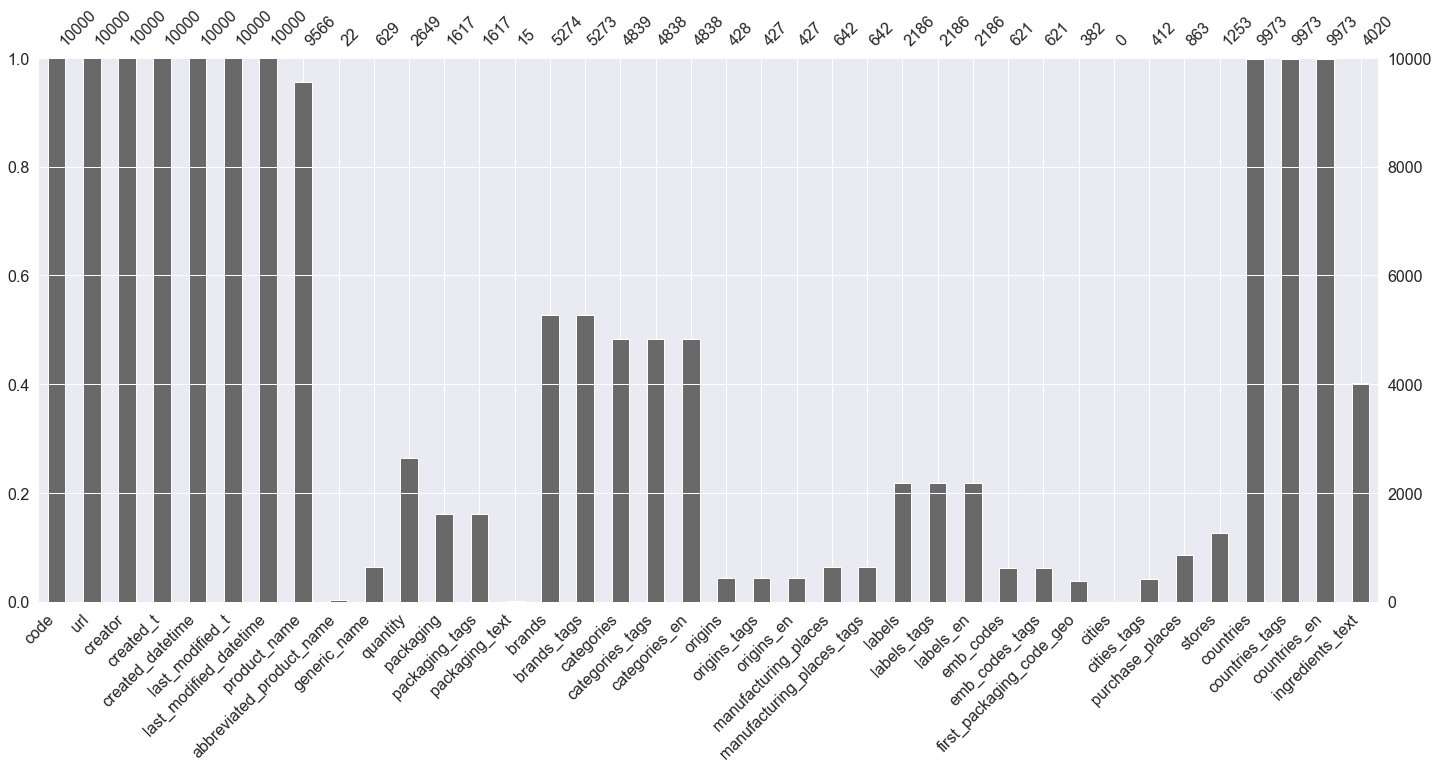

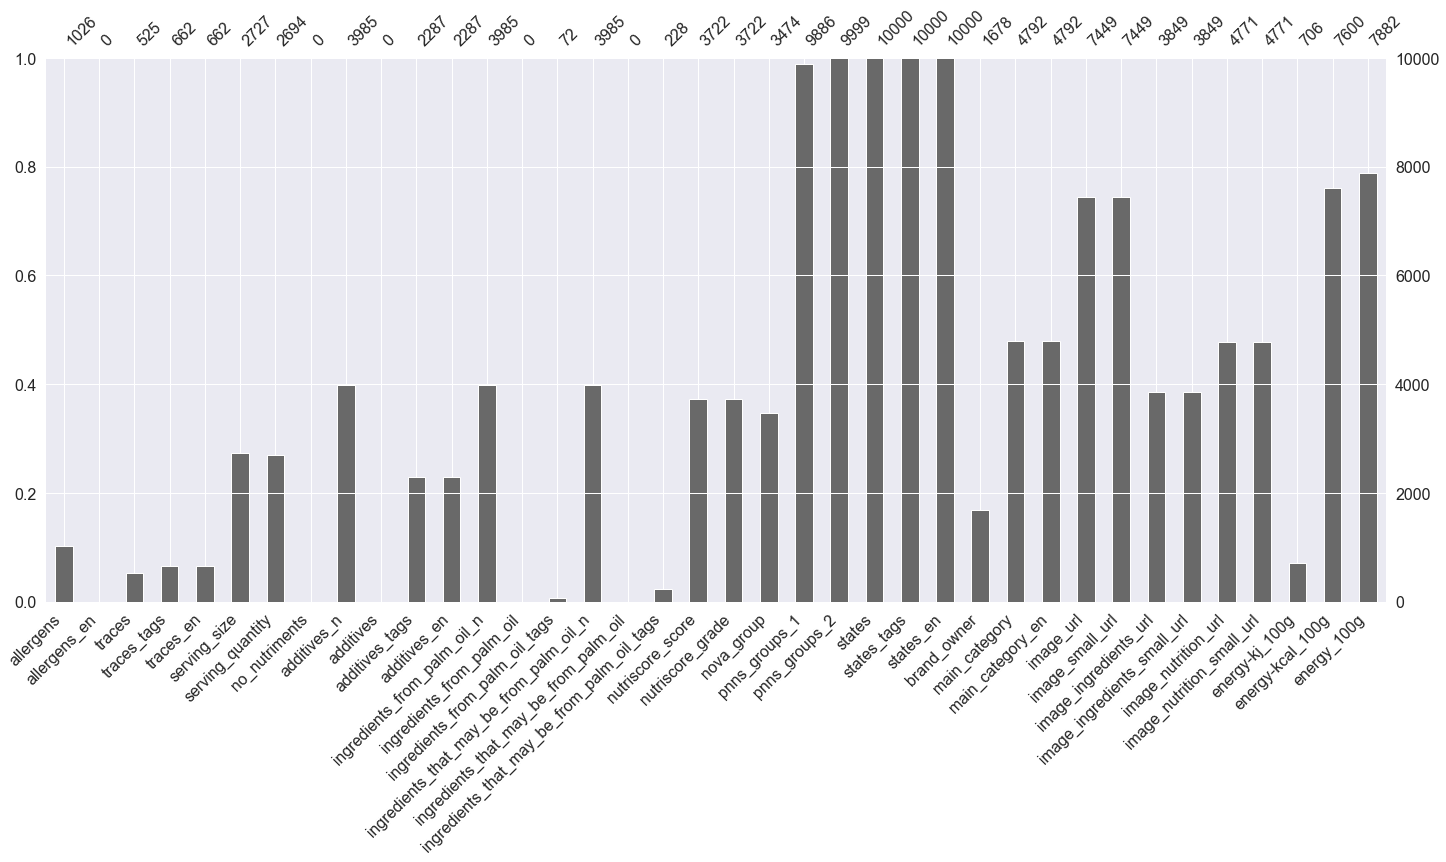

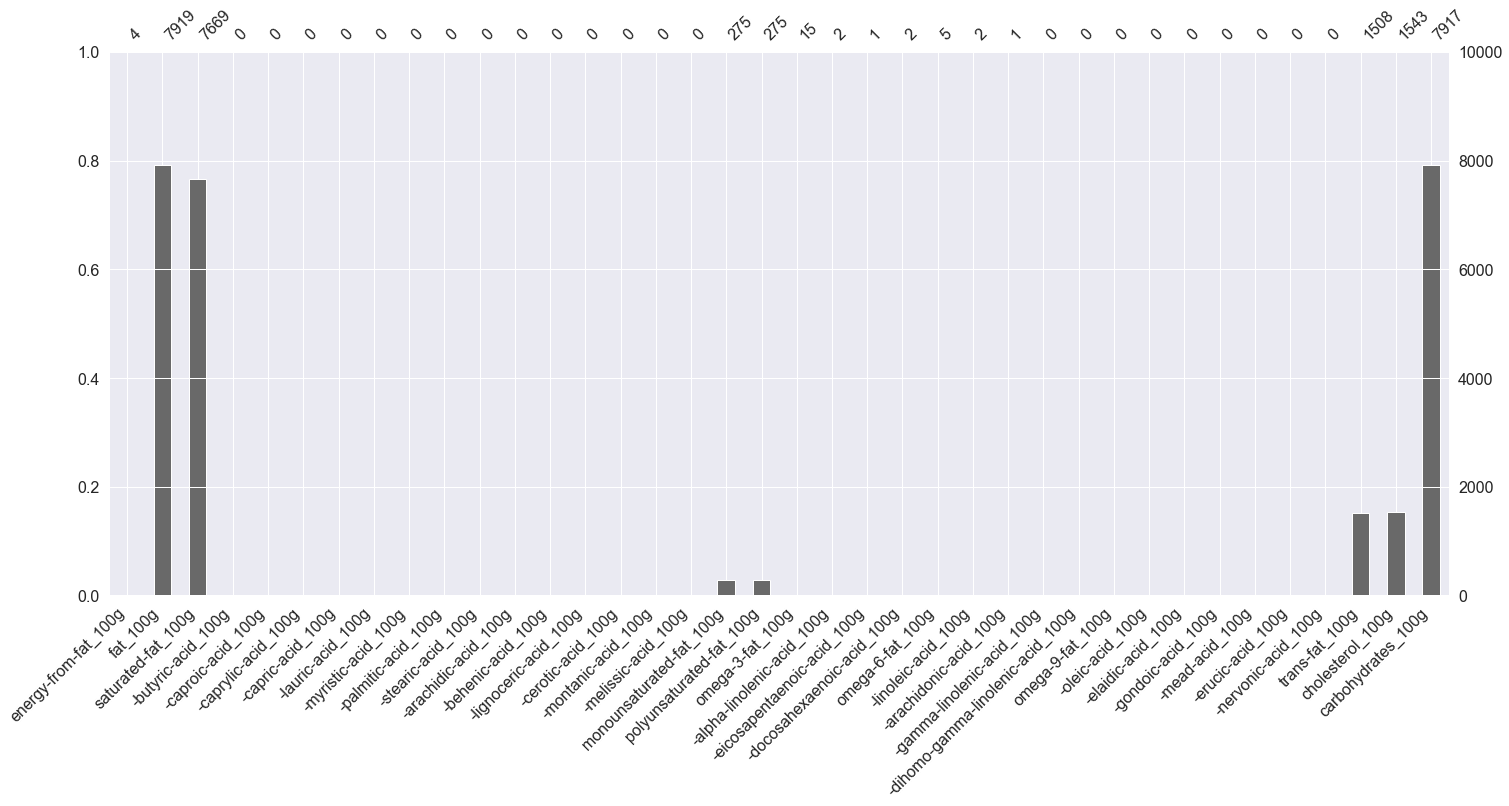

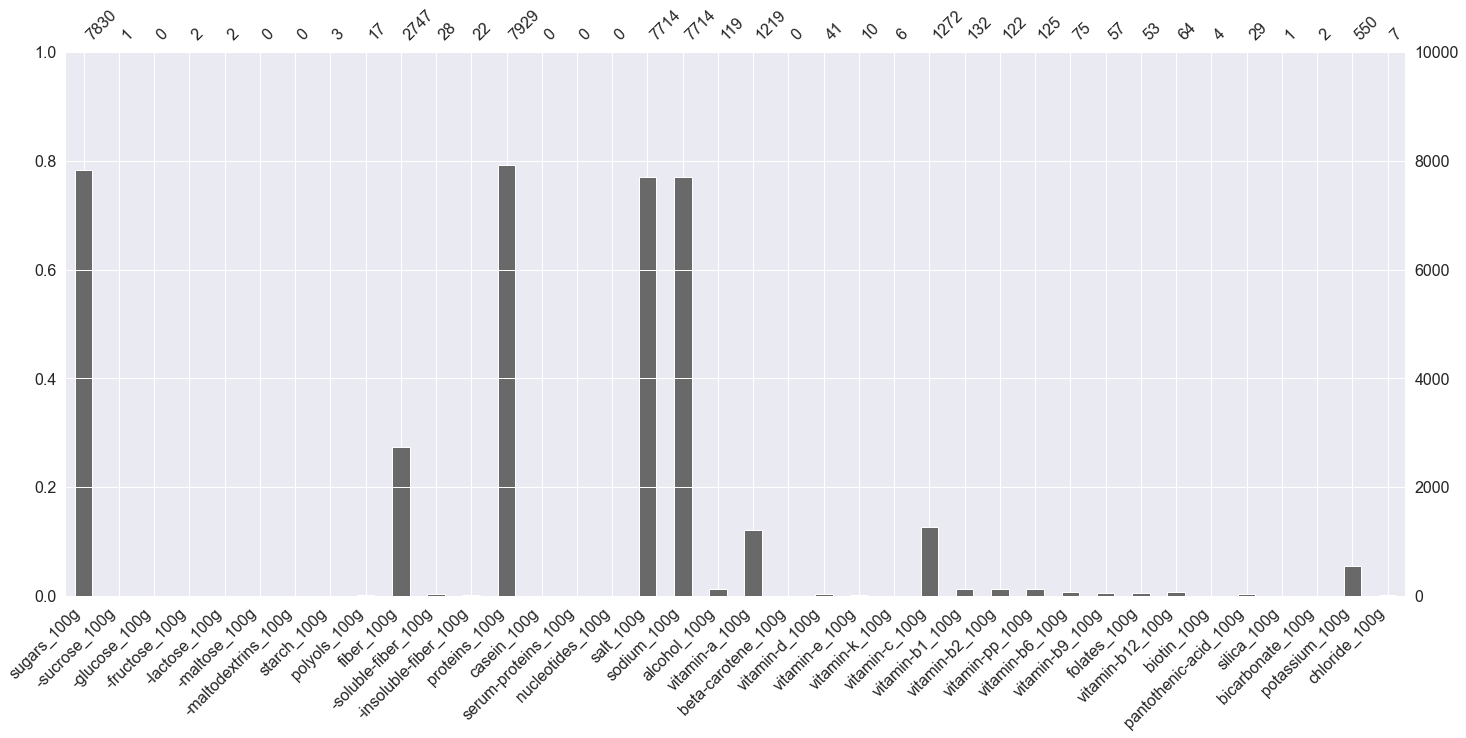

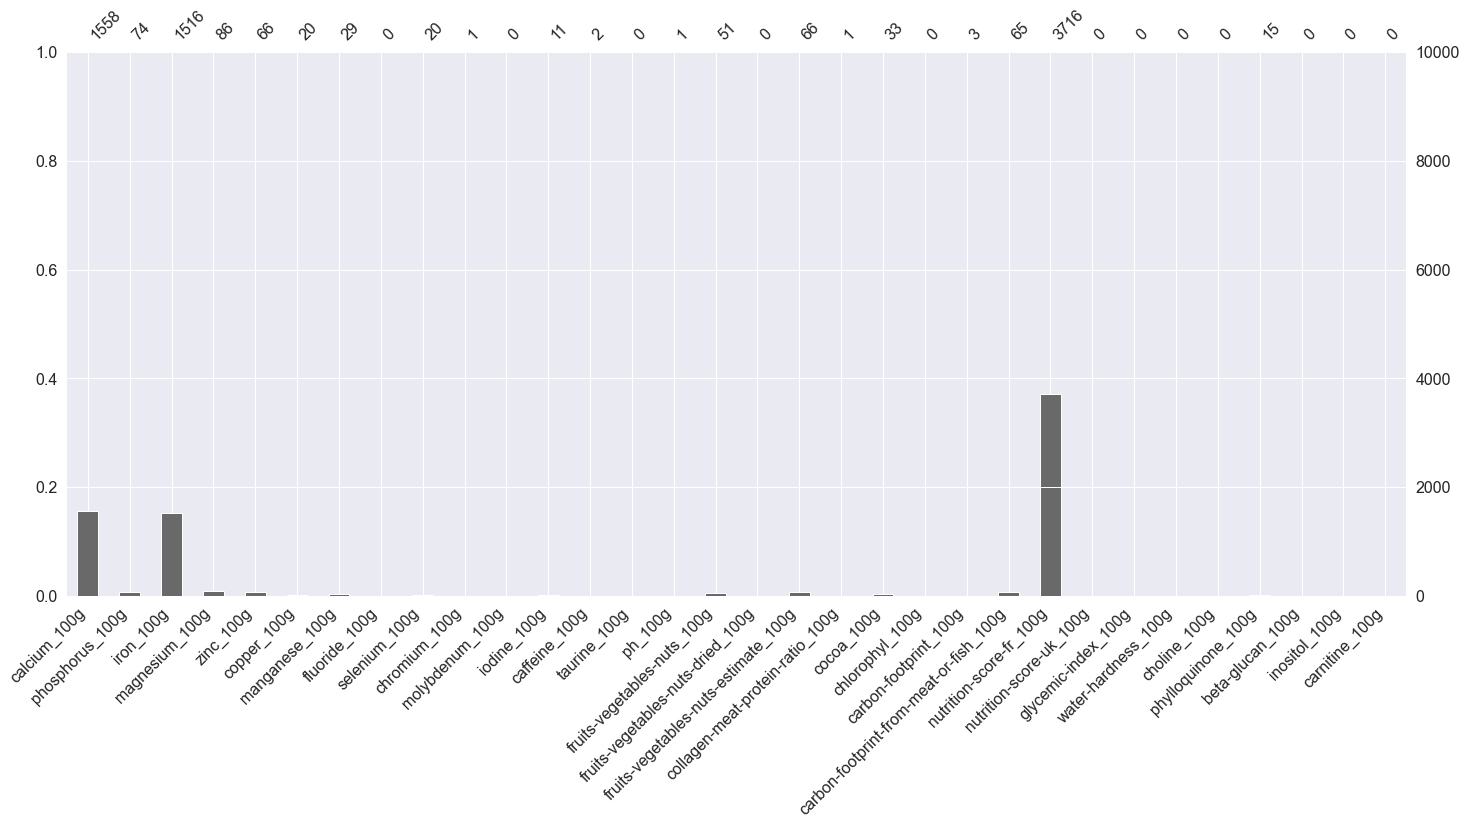

In [12]:
Part_1 = data.iloc[:,0:38]
Part_2 = data.iloc[:,38:76]
Part_3 = data.iloc[:,76:114]
Part_4 = data.iloc[:,114:152]
Part_5 = data.iloc[:,152:]
plt.figure()
msno.bar(Part_1.sample(10000))
plt.figure()
msno.bar(Part_2.sample(10000))
plt.figure()
msno.bar(Part_3.sample(10000))
plt.figure()
msno.bar(Part_4.sample(10000))
plt.figure()
msno.bar(Part_5.sample(10000))

## 4. Seuil de suppression des données manquantes à 90 % et filtres Pays = France et nutrition-score-fr_100g = renseigné

### Supprimons les colonnes (variables) qui ont plus de 90 % de données manquantes
Les graphiques précédents montrent que de nombreuses variables ont plus de 90 % de données manquantes. On peut donc les supprimer sans risquer de perdre de l'information.

In [42]:
# Nombre de lignes et de colonnes avant suppression.
data.shape

(1724219, 184)

In [43]:
data = data[data.columns[data.isna().sum()/data.shape[0] < 0.90]]  # on ne conserve que les colonnes qui ont moins de 90 % de valeurs manquantes

In [44]:
# Nombre de lignes et de colonnes aprés suppression
data.shape

(1724219, 66)

**Sans perte d'informations significatives, nous avons pu diviser par prés de trois le nombre de colonnes (de 184 à 66).**

<Figure size 432x288 with 0 Axes>

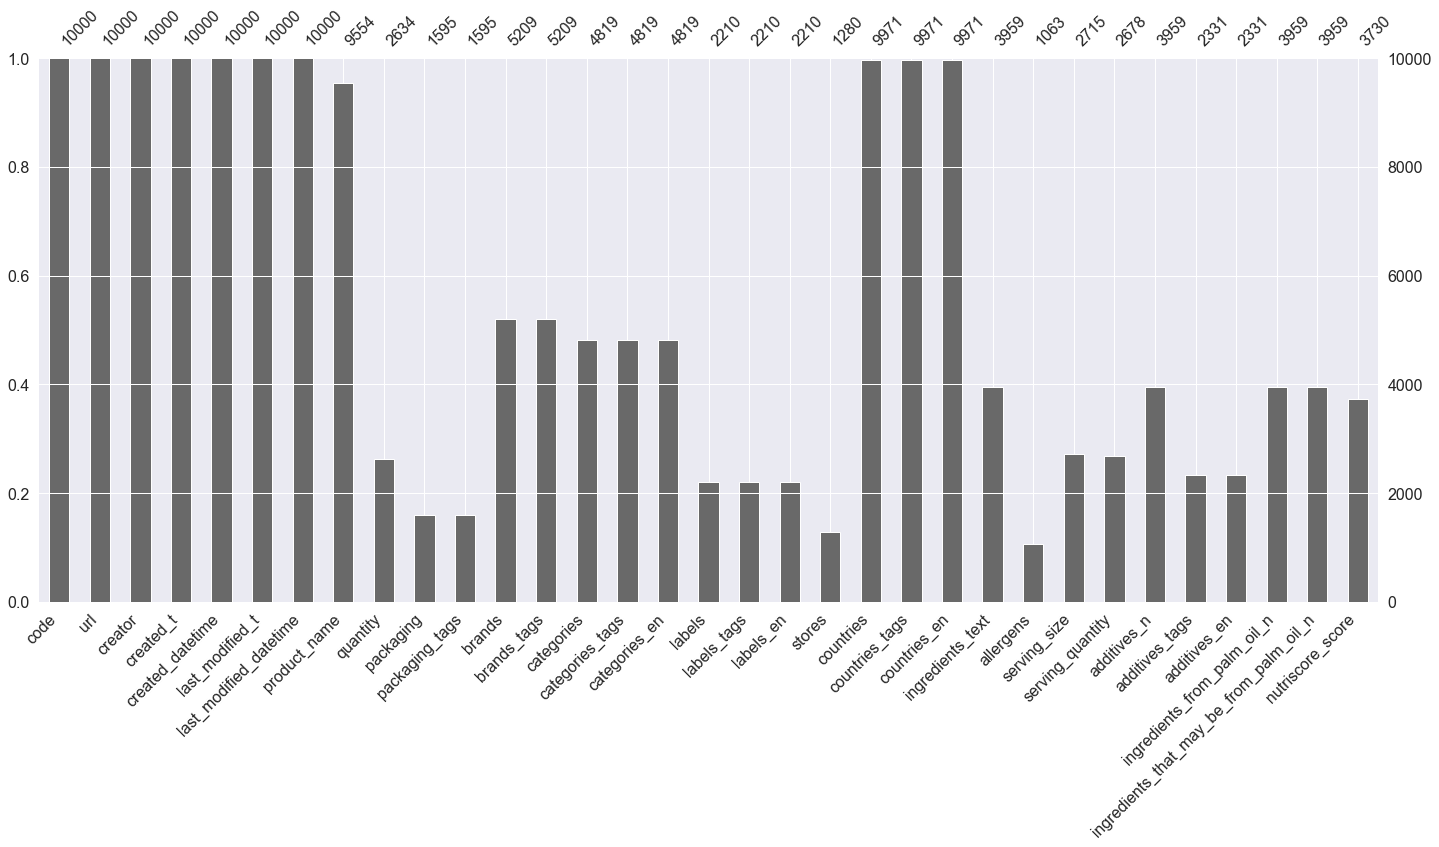

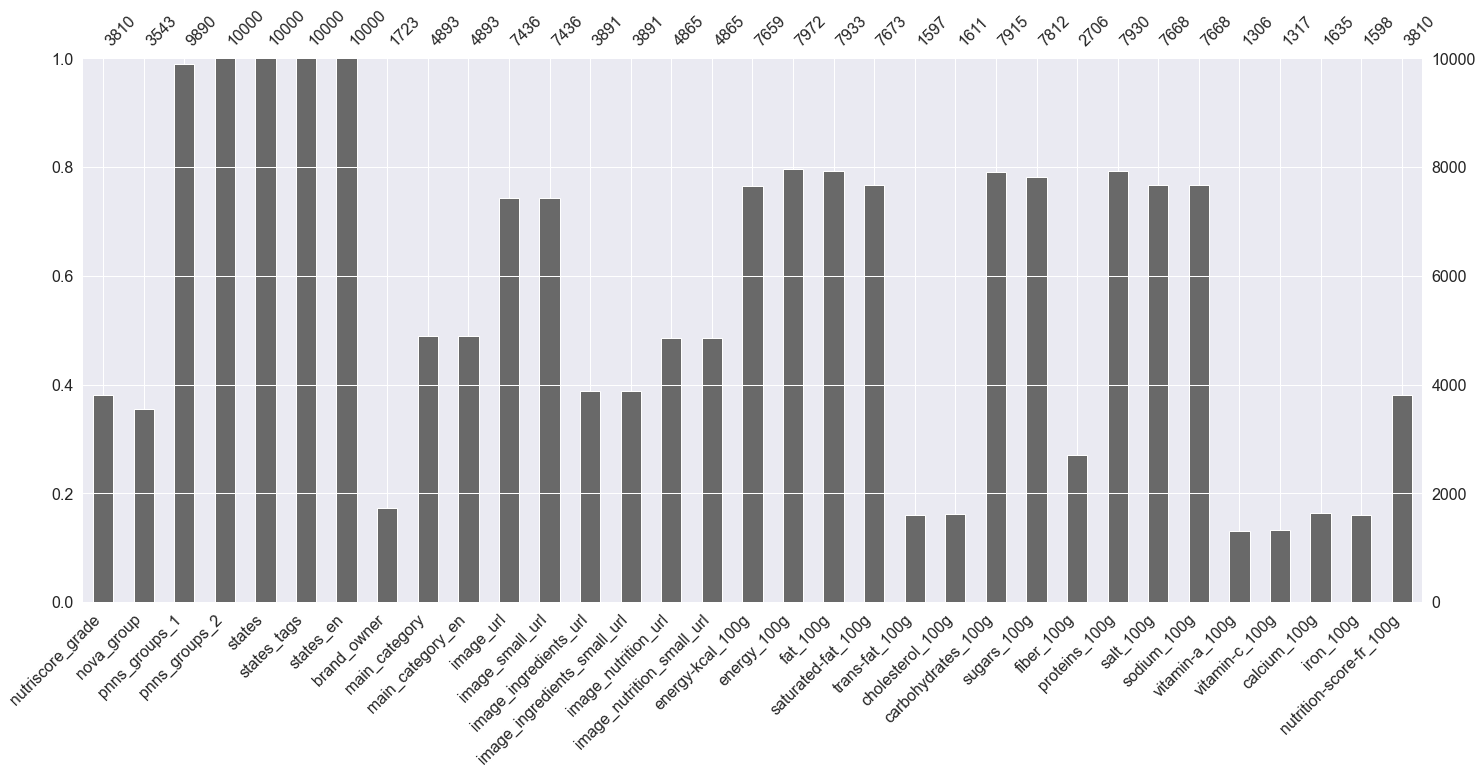

<Figure size 432x288 with 0 Axes>

In [16]:
Part_1 = data.iloc[:,0:33]
Part_2 = data.iloc[:,33:]
plt.figure()
msno.bar(Part_1.sample(10000))
plt.figure()
msno.bar(Part_2.sample(10000))
plt.figure()

### Ne garder que les lignes pour lesquelles le pays est France et le score nutrionelle_fr_100 est présent

In [45]:
data = data.loc[data['countries']=="France"] # On garde les données française uniquement
data = data.dropna(subset=['nutrition-score-fr_100g']) ### Nous conservons cette information qui sera prépondérante dans notre application
data = data.dropna(subset=['nutriscore_grade'])
data.shape

(198233, 66)

### Taux de remplissage du jeu de données

In [46]:
def filling_rate(dataframe):
    """Calcule et affiche le taux de remplissage du jeu de données"""
    
    sns.set()
    
    # Calcule le nombre de lignes et de colonnes du jeu de données
    nb_rows, nb_columns = dataframe.shape
    print('----------------------------------------------------')
    print("Le jeu de données a {} lignes et {} colonnes.".format(nb_rows,nb_columns))

    # Calculer le nombre de non-Nan dans le Dataframe
    nb_data = dataframe.count().sum()

    # Calcul du taux de remplissage du jeu de données
    filling_rate = nb_data / (nb_rows * nb_columns)
    print('------------------------------------------------------')
    print("Le taux de remplissage global du jeu est de : {:.2%}".format(filling_rate))
    print('------------------------------------------------------')
      
    # Fréquences et labels pour le pie plot
    frequencies = [filling_rate, 1 - filling_rate]
    labels = ["Données présentes", "Données manquantes"]
    
    # Informations générales pour le pie plot
    fig, ax = plt.subplots(figsize=(5, 5))
    plt.title("Taux de remplissage du jeu de données", fontsize=15)
    ax.axis("equal")
    explode = (0.1, 0)  # only "explode" the 1st slice

    # Affichage du pie plot
    ax.pie(frequencies,
           explode=explode,
           # labels=labels,
           autopct='%1.2f%%',
           shadow=True,
          )
    plt.legend(labels)

JEU DE DONNEES INITIAL
----------------------------------------------------
Le jeu de données a 1724219 lignes et 184 colonnes.
------------------------------------------------------
Le taux de remplissage global du jeu est de : 20.47%
------------------------------------------------------


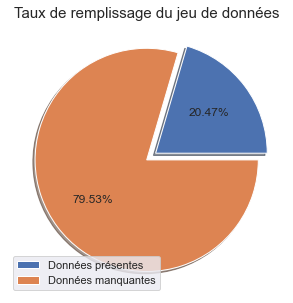

In [47]:
print('JEU DE DONNEES INITIAL')
filling_rate(data_origine)

JEU DE DONNEES RETRAITE
----------------------------------------------------
Le jeu de données a 198233 lignes et 66 colonnes.
------------------------------------------------------
Le taux de remplissage global du jeu est de : 72.99%
------------------------------------------------------


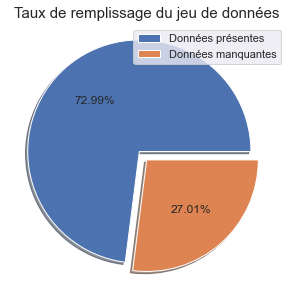

In [48]:
print('JEU DE DONNEES RETRAITE')
filling_rate(data)

In [49]:
print('--------------------------------------------------')
nb_rows, nb_columns = data.shape
# Nombre de valeurs dans chaque colonne
columns_count = data.count().sort_values(ascending=False)
# Calcul du taux de remplissage par colonne
filling_rate_column = round((columns_count / nb_rows)*100,2)
print('Taux de remplissage de chaque colonne en %')
# Taux de remplissage de chaque colonne
filling_rate_column

--------------------------------------------------
Taux de remplissage de chaque colonne en %


code                                       100.00
categories_tags                            100.00
main_category_en                           100.00
main_category                              100.00
states_en                                  100.00
states_tags                                100.00
states                                     100.00
pnns_groups_2                              100.00
url                                        100.00
nutriscore_score                           100.00
countries_en                               100.00
countries_tags                             100.00
countries                                  100.00
categories_en                              100.00
nutriscore_grade                           100.00
categories                                 100.00
last_modified_datetime                     100.00
creator                                    100.00
created_t                                  100.00
created_datetime                           100.00


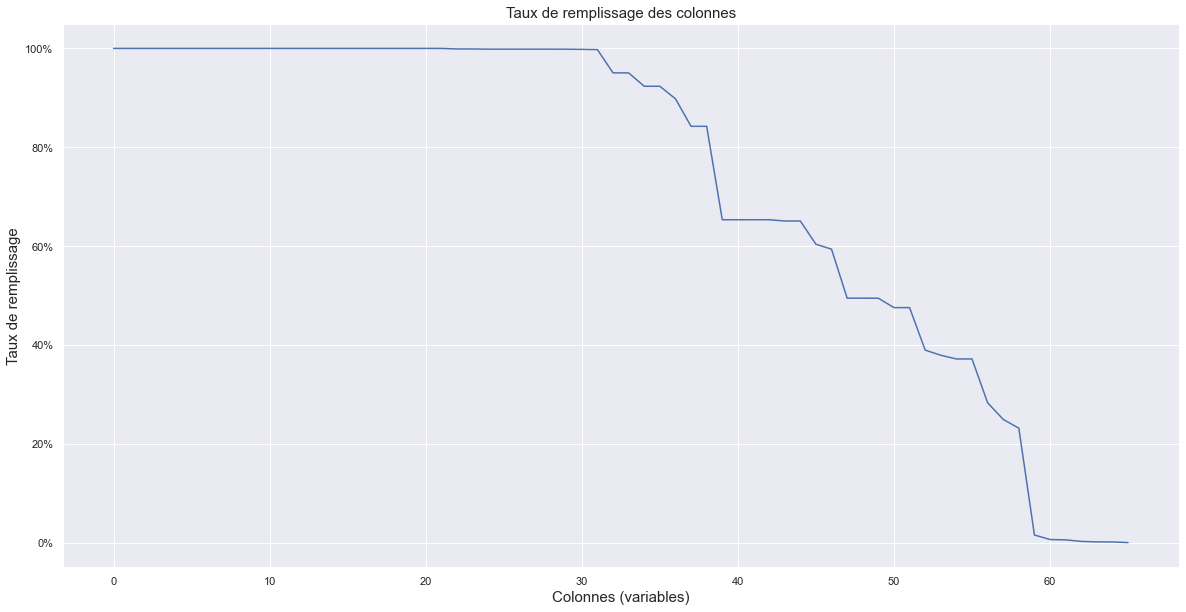

In [50]:
# Représentation graphique du taux de remplissage des colonnes

sns.set()

x = range(nb_columns)
y = filling_rate_column / 100

fig, ax = plt.subplots(figsize=(20, 10))
plt.title("Taux de remplissage des colonnes", fontsize=15)
plt.xlabel("Colonnes (variables)", fontsize=15)
plt.ylabel("Taux de remplissage", fontsize=15)
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
plot = ax.plot(x, y)

In [21]:
data.head()

code                                                url  creator  \
3   0000000000100  http://world-en.openfoodfacts.org/product/0000...    del51   
14  0000000000949  http://world-en.openfoodfacts.org/product/0000...  kiliweb   
23  0000000001281  http://world-en.openfoodfacts.org/product/0000...  kiliweb   
33  0000000001885  http://world-en.openfoodfacts.org/product/0000...  kiliweb   
37  0000000002257  http://world-en.openfoodfacts.org/product/0000...  kiliweb   

     created_t      created_datetime  last_modified_t last_modified_datetime  \
3   1444572561  2015-10-11T14:09:21Z       1444659212   2015-10-12T14:13:32Z   
14  1523440813  2018-04-11T10:00:13Z       1565268412   2019-08-08T12:46:52Z   
23  1517830801  2018-02-05T11:40:01Z       1527070794   2018-05-23T10:19:54Z   
33  1511180337  2017-11-20T12:18:57Z       1518126491   2018-02-08T21:48:11Z   
37  1520506122  2018-03-08T10:48:42Z       1561463749   2019-06-25T11:55:49Z   

                      product_name quantity            packaging  \
3      moutarde au moût de raisin      100g                  NaN   
14       Salade de carottes râpées      NaN                  NaN   
23              Tarte noix de coco      NaN  barquette,plastique   
33                Compote de poire      NaN                  NaN   
37  Salade de macedoine de légumes      NaN                  NaN   

         packaging_tags              brands        brands_tags  \
3                   NaN       courte paille      courte-paille   
14                  NaN                 NaN                NaN   
23  barquette,plastique  Crous Resto',Crous  crous-resto,crous   
33                  NaN               Crous              crous   
37                  NaN                 NaN                NaN   

                                           categories  \
3             Epicerie, Condiments, Sauces, Moutardes   
14  Plats préparés, Légumes préparés, Carottes râp...   
23   Tartes, Tartes sucrées, Tartes à la noix de coco   
33  Aliments et boissons à base de végétaux, Alime...   
37  Plats préparés, Légumes préparés, Entrées, Ent...   

                                      categories_tags  \
3    en:groceries,en:condiments,en:sauces,en:mustards   
14  en:meals,en:prepared-vegetables,en:grated-carr...   
23              en:pies,en:sweet-pies,en:coconut-pies   
33  en:plant-based-foods-and-beverages,en:plant-ba...   
37  en:meals,en:prepared-vegetables,en:starters,en...   

                                        categories_en         labels  \
3                Groceries,Condiments,Sauces,Mustards  Delois france   
14  Meals,Prepared vegetables,Grated carrots,Seaso...            NaN   
23                       Pies,Sweet pies,Coconut pies            NaN   
33  Plant-based foods and beverages,Plant-based fo...            NaN   
37  Meals,Prepared vegetables,Starters,Cold starte...            NaN   

         labels_tags         labels_en         stores countries  \
3   fr:delois-france  fr:delois-france  courte paille    France   
14               NaN               NaN            NaN    France   
23               NaN               NaN            NaN    France   
33               NaN               NaN            NaN    France   
37               NaN               NaN            NaN    France   

   countries_tags countries_en  \
3       en:france       France   
14      en:france       France   
23      en:france       France   
33      en:france       France   
37      en:france       France   

                                     ingredients_text   allergens  \
3   eau graines de téguments de moutarde vinaigre ...  en:mustard   
14                                                NaN         NaN   
23                                                NaN         NaN   
33                                                NaN         NaN   
37                                                NaN         NaN   

   serving_size  serving_quantity  additives_n additives_tags additives_en  \
3           NaN    

## 5. Typage des données

<AxesSubplot:ylabel='None'>

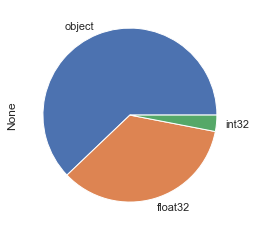

In [51]:
data.dtypes.value_counts().plot.pie()

* **Colonnes 'object'**

In [23]:
data.select_dtypes('object').head()

code                                                url  creator  \
3   0000000000100  http://world-en.openfoodfacts.org/product/0000...    del51   
14  0000000000949  http://world-en.openfoodfacts.org/product/0000...  kiliweb   
23  0000000001281  http://world-en.openfoodfacts.org/product/0000...  kiliweb   
33  0000000001885  http://world-en.openfoodfacts.org/product/0000...  kiliweb   
37  0000000002257  http://world-en.openfoodfacts.org/product/0000...  kiliweb   

        created_datetime last_modified_datetime  \
3   2015-10-11T14:09:21Z   2015-10-12T14:13:32Z   
14  2018-04-11T10:00:13Z   2019-08-08T12:46:52Z   
23  2018-02-05T11:40:01Z   2018-05-23T10:19:54Z   
33  2017-11-20T12:18:57Z   2018-02-08T21:48:11Z   
37  2018-03-08T10:48:42Z   2019-06-25T11:55:49Z   

                      product_name quantity            packaging  \
3      moutarde au moût de raisin      100g                  NaN   
14       Salade de carottes râpées      NaN                  NaN   
23              Tarte noix de coco      NaN  barquette,plastique   
33                Compote de poire      NaN                  NaN   
37  Salade de macedoine de légumes      NaN                  NaN   

         packaging_tags              brands        brands_tags  \
3                   NaN       courte paille      courte-paille   
14                  NaN                 NaN                NaN   
23  barquette,plastique  Crous Resto',Crous  crous-resto,crous   
33                  NaN               Crous              crous   
37                  NaN                 NaN                NaN   

                                           categories  \
3             Epicerie, Condiments, Sauces, Moutardes   
14  Plats préparés, Légumes préparés, Carottes râp...   
23   Tartes, Tartes sucrées, Tartes à la noix de coco   
33  Aliments et boissons à base de végétaux, Alime...   
37  Plats préparés, Légumes préparés, Entrées, Ent...   

                                      categories_tags  \
3    en:groceries,en:condiments,en:sauces,en:mustards   
14  en:meals,en:prepared-vegetables,en:grated-carr...   
23              en:pies,en:sweet-pies,en:coconut-pies   
33  en:plant-based-foods-and-beverages,en:plant-ba...   
37  en:meals,en:prepared-vegetables,en:starters,en...   

                                        categories_en         labels  \
3                Groceries,Condiments,Sauces,Mustards  Delois france   
14  Meals,Prepared vegetables,Grated carrots,Seaso...            NaN   
23                       Pies,Sweet pies,Coconut pies            NaN   
33  Plant-based foods and beverages,Plant-based fo...            NaN   
37  Meals,Prepared vegetables,Starters,Cold starte...            NaN   

         labels_tags         labels_en         stores countries  \
3   fr:delois-france  fr:delois-france  courte paille    France   
14               NaN               NaN            NaN    France   
23               NaN               NaN            NaN    France   
33               NaN               NaN            NaN    France   
37               NaN               NaN            NaN    France   

   countries_tags countries_en  \
3       en:france       France   
14      en:france       France   
23      en:france       France   
33      en:france       France   
37      en:france       France   

                                     ingredients_text   allergens  \
3   eau graines de téguments de moutarde vinaigre ...  en:mustard   
14                                                NaN         NaN   
23                                                NaN         NaN   
33                                                NaN         NaN   
37                                                NaN         NaN   

   serving_size additives_tags additives_en nutriscore_grade  \
3           NaN            NaN          NaN                d   
14          NaN            NaN          NaN                b   
23          NaN            NaN          NaN                d   
33          NaN

* **Effectifs des modalités des colonnes ['object']**

In [52]:
columns = data.select_dtypes('object').columns.tolist()
for column in columns:
    x = data[column].value_counts()
    print('---------------------------------------------------------------')
    print('Effectif des modalités de la colonne :', column)
    print(x)

---------------------------------------------------------------
Effectif des modalités de la colonne : code
30383354190402    2
2860060019880     1
3410280019772     1
26021034          1
13636661          1
                 ..
26046631          1
3256224702061     1
3760197636853     1
2573123006207     1
2602659032210     1
Name: code, Length: 198232, dtype: int64
---------------------------------------------------------------
Effectif des modalités de la colonne : url
http://world-en.openfoodfacts.org/product/30383354190402/basilic-panzani                                         2
http://world-en.openfoodfacts.org/product/8023074000556/mozzarella-di-bufala-cup-25x20gr-campan-tre-stelle       1
http://world-en.openfoodfacts.org/product/3390125005385/nectar-de-peche-bio-feria-de-fruits                      1
http://world-en.openfoodfacts.org/product/3427290002335/mais-grille-sale-le-temps-des-saisons                    1
http://world-en.openfoodfacts.org/product/3760148291599/sardines

* **Liste des colonnes ['object'] à convertir en 'category**

In [53]:
liste_col_category = ['creator', 'product_name', 'quantity', 'packaging', 'packaging_tags', 'brands', 'brands_tags', 'categories', 'categories_tags', 'categories_en', 'labels', 'labels_tags', 'labels_en', 'serving_size', 'additives_tags', 'additives_en', 'nutriscore_grade', 'pnns_groups_1', 'pnns_groups_2', 'main_category', 'main_category_en']

* **Conversion des types 'object' vers le type 'category'**

In [54]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 198233 entries, 3 to 1724211
Data columns (total 66 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   code                                     198233 non-null  object 
 1   url                                      198233 non-null  object 
 2   creator                                  198233 non-null  object 
 3   created_t                                198233 non-null  int32  
 4   created_datetime                         198233 non-null  object 
 5   last_modified_t                          198233 non-null  int32  
 6   last_modified_datetime                   198233 non-null  object 
 7   product_name                             197907 non-null  object 
 8   quantity                                 117707 non-null  object 
 9   packaging                                94274 non-null   object 
 10  packaging_tags                 

In [ ]:
for col in data.select_dtypes('object').columns:
        data.select_dtypes('object')[col] = data.select_dtypes('object')[col].astype('category')

In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 198233 entries, 3 to 1724211
Data columns (total 66 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   code                                     198233 non-null  object 
 1   url                                      198233 non-null  object 
 2   creator                                  198233 non-null  object 
 3   created_t                                198233 non-null  int32  
 4   created_datetime                         198233 non-null  object 
 5   last_modified_t                          198233 non-null  int32  
 6   last_modified_datetime                   198233 non-null  object 
 7   product_name                             197907 non-null  object 
 8   quantity                                 117707 non-null  object 
 9   packaging                                94274 non-null   object 
 10  packaging_tags                 

### Format timestamp des colonnes


In [57]:
#Observation des colonnes qui contiennent le _t et le _datetime
print(data.iloc[:,data.columns.str.endswith('_t')].head())
print('\n', data.iloc[:,data.columns.str.endswith('_datetime')].head())

     created_t  last_modified_t
3   1444572561       1444659212
14  1523440813       1565268412
23  1517830801       1527070794
33  1511180337       1518126491
37  1520506122       1561463749

         created_datetime last_modified_datetime
3   2015-10-11T14:09:21Z   2015-10-12T14:13:32Z
14  2018-04-11T10:00:13Z   2019-08-08T12:46:52Z
23  2018-02-05T11:40:01Z   2018-05-23T10:19:54Z
33  2017-11-20T12:18:57Z   2018-02-08T21:48:11Z
37  2018-03-08T10:48:42Z   2019-06-25T11:55:49Z


In [58]:
liste_timestamp = []
liste_timestamp_t = data.loc[:, data.columns.str.endswith('_t')].columns.tolist()
liste_timestamp_datetime = data.loc[:, data.columns.str.endswith('_datetime')].columns.tolist()
liste_timestamp = liste_timestamp_t + liste_timestamp_datetime
liste_timestamp

['created_t', 'last_modified_t', 'created_datetime', 'last_modified_datetime']

In [59]:
for col in liste_timestamp:
       data[col] = pd.to_datetime(data[col]) 
        
print(data.iloc[:,data.columns.str.endswith('_t')].head())
print('\n', data.iloc[:,data.columns.str.endswith('_datetime')].head())

                       created_t               last_modified_t
3  1970-01-01 00:00:01.444572561 1970-01-01 00:00:01.444659212
14 1970-01-01 00:00:01.523440813 1970-01-01 00:00:01.565268412
23 1970-01-01 00:00:01.517830801 1970-01-01 00:00:01.527070794
33 1970-01-01 00:00:01.511180337 1970-01-01 00:00:01.518126491
37 1970-01-01 00:00:01.520506122 1970-01-01 00:00:01.561463749

             created_datetime    last_modified_datetime
3  2015-10-11 14:09:21+00:00 2015-10-12 14:13:32+00:00
14 2018-04-11 10:00:13+00:00 2019-08-08 12:46:52+00:00
23 2018-02-05 11:40:01+00:00 2018-05-23 10:19:54+00:00
33 2017-11-20 12:18:57+00:00 2018-02-08 21:48:11+00:00
37 2018-03-08 10:48:42+00:00 2019-06-25 11:55:49+00:00


### Types du jeu de données aprés transtypage

<AxesSubplot:ylabel='None'>

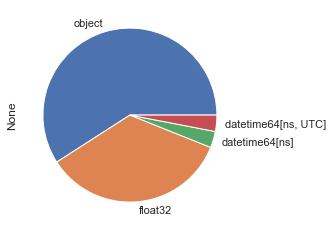

In [60]:
data.dtypes.value_counts().plot.pie()

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 198233 entries, 3 to 1724211
Data columns (total 66 columns):
 #   Column                                   Non-Null Count   Dtype              
---  ------                                   --------------   -----              
 0   code                                     198233 non-null  object             
 1   url                                      198233 non-null  object             
 2   creator                                  198233 non-null  object             
 3   created_t                                198233 non-null  datetime64[ns]     
 4   created_datetime                         198233 non-null  datetime64[ns, UTC]
 5   last_modified_t                          198233 non-null  datetime64[ns]     
 6   last_modified_datetime                   198233 non-null  datetime64[ns, UTC]
 7   product_name                             197907 non-null  object             
 8   quantity                                 117707 non-n

## 6. Sélection des colonnes (variables)
Chaque colonne correspond à une variable (feature), et chaque ligne correspond à un produit.

In [61]:
# Liste des noms de colonnes
print("Noms de colonnes :", list(data))

Noms de colonnes : ['code', 'url', 'creator', 'created_t', 'created_datetime', 'last_modified_t', 'last_modified_datetime', 'product_name', 'quantity', 'packaging', 'packaging_tags', 'brands', 'brands_tags', 'categories', 'categories_tags', 'categories_en', 'labels', 'labels_tags', 'labels_en', 'stores', 'countries', 'countries_tags', 'countries_en', 'ingredients_text', 'allergens', 'serving_size', 'serving_quantity', 'additives_n', 'additives_tags', 'additives_en', 'ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n', 'nutriscore_score', 'nutriscore_grade', 'nova_group', 'pnns_groups_1', 'pnns_groups_2', 'states', 'states_tags', 'states_en', 'brand_owner', 'main_category', 'main_category_en', 'image_url', 'image_small_url', 'image_ingredients_url', 'image_ingredients_small_url', 'image_nutrition_url', 'image_nutrition_small_url', 'energy-kcal_100g', 'energy_100g', 'fat_100g', 'saturated-fat_100g', 'trans-fat_100g', 'cholesterol_100g', 'carbohydrates_100g', 'sugars_

In [38]:
data.head()

code                                                url  creator  \
3   0000000000100  http://world-en.openfoodfacts.org/product/0000...    del51   
14  0000000000949  http://world-en.openfoodfacts.org/product/0000...  kiliweb   
23  0000000001281  http://world-en.openfoodfacts.org/product/0000...  kiliweb   
33  0000000001885  http://world-en.openfoodfacts.org/product/0000...  kiliweb   
37  0000000002257  http://world-en.openfoodfacts.org/product/0000...  kiliweb   

                       created_t          created_datetime  \
3  1970-01-01 00:00:01.444572561 2015-10-11 14:09:21+00:00   
14 1970-01-01 00:00:01.523440813 2018-04-11 10:00:13+00:00   
23 1970-01-01 00:00:01.517830801 2018-02-05 11:40:01+00:00   
33 1970-01-01 00:00:01.511180337 2017-11-20 12:18:57+00:00   
37 1970-01-01 00:00:01.520506122 2018-03-08 10:48:42+00:00   

                 last_modified_t    last_modified_datetime  \
3  1970-01-01 00:00:01.444659212 2015-10-12 14:13:32+00:00   
14 1970-01-01 00:00:01.565268412 2019-08-08 12:46:52+00:00   
23 1970-01-01 00:00:01.527070794 2018-05-23 10:19:54+00:00   
33 1970-01-01 00:00:01.518126491 2018-02-08 21:48:11+00:00   
37 1970-01-01 00:00:01.561463749 2019-06-25 11:55:49+00:00   

                      product_name quantity            packaging  \
3      moutarde au moût de raisin      100g                  NaN   
14       Salade de carottes râpées      NaN                  NaN   
23              Tarte noix de coco      NaN  barquette,plastique   
33                Compote de poire      NaN                  NaN   
37  Salade de macedoine de légumes      NaN                  NaN   

         packaging_tags              brands        brands_tags  \
3                   NaN       courte paille      courte-paille   
14                  NaN                 NaN                NaN   
23  barquette,plastique  Crous Resto',Crous  crous-resto,crous   
33                  NaN               Crous              crous   
37                  NaN                 NaN                NaN   

                                           categories  \
3             Epicerie, Condiments, Sauces, Moutardes   
14  Plats préparés, Légumes préparés, Carottes râp...   
23   Tartes, Tartes sucrées, Tartes à la noix de coco   
33  Aliments et boissons à base de végétaux, Alime...   
37  Plats préparés, Légumes préparés, Entrées, Ent...   

                                      categories_tags  \
3    en:groceries,en:condiments,en:sauces,en:mustards   
14  en:meals,en:prepared-vegetables,en:grated-carr...   
23              en:pies,en:sweet-pies,en:coconut-pies   
33  en:plant-based-foods-and-beverages,en:plant-ba...   
37  en:meals,en:prepared-vegetables,en:starters,en...   

                                        categories_en         labels  \
3                Groceries,Condiments,Sauces,Mustards  Delois france   
14  Meals,Prepared vegetables,Grated carrots,Seaso...            NaN   
23                       Pies,Sweet pies,Coconut pies            NaN   
33  Plant-based foods and beverages,Plant-based fo...            NaN   
37  Meals,Prepared vegetables,Starters,Cold starte...            NaN   

         labels_tags         labels_en         stores countries  \
3   fr:delois-france  fr:delois-france  courte paille    France   
14               NaN               NaN            NaN    France   
23               NaN               NaN            NaN    France   
33               NaN               NaN            NaN    France   
37               NaN               NaN            NaN    France   

   countries_tags countries_en  \
3       en:france       France   
14      en:france       France   
23      en:france       France   
33      en:france       France   
37      en:france       France   

                                     ingredients_text   allergens  \
3   eau graines de téguments de moutarde vinaigre ...  en:mustard   
14                                                NaN         NaN   
23                                      

Comme indiqué dans l'appel à projet, les champs sont séparés en sections. Mais selon le descriptif des données sur le site  [openfoodfacts.org](https://world.openfoodfacts.org/data/data-fields.txt), il y a 5 sections. 

1. "*general informations*" : les informations générales sur la fiche du produit
   * de la colonne 'code'…
   * … à la colonne 'quantity'
2. "*tags*" : un ensemble de tags
   * de la colonne 'packaging'…
   * … à la colonne 'countries_fr'
3. "*ingredients*": les ingrédients et additifs éventuels.
   * de la colonne 'ingredients_text'…
   * … à la colonne 'traces_tags'
4. "*misc. data*" : des informations diverses
   * de la colonne 'serving_size'…
   * … à la colonne 'image_small_url'
5. "*nutrition facts*" : des informations nutritionnelles
   * de la colonne 'energy_100g'…
   * … à la colonne 'nutrition-score-uk_100g'

* **Informations générales sur la fiche du produit**

In [39]:
infos_produits = data.loc[:, 'code':'quantity']
infos_produits.head()

code                                                url  creator  \
3   0000000000100  http://world-en.openfoodfacts.org/product/0000...    del51   
14  0000000000949  http://world-en.openfoodfacts.org/product/0000...  kiliweb   
23  0000000001281  http://world-en.openfoodfacts.org/product/0000...  kiliweb   
33  0000000001885  http://world-en.openfoodfacts.org/product/0000...  kiliweb   
37  0000000002257  http://world-en.openfoodfacts.org/product/0000...  kiliweb   

                       created_t          created_datetime  \
3  1970-01-01 00:00:01.444572561 2015-10-11 14:09:21+00:00   
14 1970-01-01 00:00:01.523440813 2018-04-11 10:00:13+00:00   
23 1970-01-01 00:00:01.517830801 2018-02-05 11:40:01+00:00   
33 1970-01-01 00:00:01.511180337 2017-11-20 12:18:57+00:00   
37 1970-01-01 00:00:01.520506122 2018-03-08 10:48:42+00:00   

                 last_modified_t    last_modified_datetime  \
3  1970-01-01 00:00:01.444659212 2015-10-12 14:13:32+00:00   
14 1970-01-01 00:00:01.565268412 2019-08-08 12:46:52+00:00   
23 1970-01-01 00:00:01.527070794 2018-05-23 10:19:54+00:00   
33 1970-01-01 00:00:01.518126491 2018-02-08 21:48:11+00:00   
37 1970-01-01 00:00:01.561463749 2019-06-25 11:55:49+00:00   

                      product_name quantity  
3      moutarde au moût de raisin      100g  
14       Salade de carottes râpées      NaN  
23              Tarte noix de coco      NaN  
33                Compote de poire      NaN  
37  Salade de macedoine de légumes      NaN

 * **Tags**

In [40]:
tags = data.loc[:,'packaging' : 'countries_en']
tags.head()

packaging       packaging_tags              brands  \
3                   NaN                  NaN       courte paille   
14                  NaN                  NaN                 NaN   
23  barquette,plastique  barquette,plastique  Crous Resto',Crous   
33                  NaN                  NaN               Crous   
37                  NaN                  NaN                 NaN   

          brands_tags                                         categories  \
3       courte-paille            Epicerie, Condiments, Sauces, Moutardes   
14                NaN  Plats préparés, Légumes préparés, Carottes râp...   
23  crous-resto,crous   Tartes, Tartes sucrées, Tartes à la noix de coco   
33              crous  Aliments et boissons à base de végétaux, Alime...   
37                NaN  Plats préparés, Légumes préparés, Entrées, Ent...   

                                      categories_tags  \
3    en:groceries,en:condiments,en:sauces,en:mustards   
14  en:meals,en:prepared-vegetables,en:grated-carr...   
23              en:pies,en:sweet-pies,en:coconut-pies   
33  en:plant-based-foods-and-beverages,en:plant-ba...   
37  en:meals,en:prepared-vegetables,en:starters,en...   

                                        categories_en         labels  \
3                Groceries,Condiments,Sauces,Mustards  Delois france   
14  Meals,Prepared vegetables,Grated carrots,Seaso...            NaN   
23                       Pies,Sweet pies,Coconut pies            NaN   
33  Plant-based foods and beverages,Plant-based fo...            NaN   
37  Meals,Prepared vegetables,Starters,Cold starte...            NaN   

         labels_tags         labels_en         stores countries  \
3   fr:delois-france  fr:delois-france  courte paille    France   
14               NaN               NaN            NaN    France   
23               NaN               NaN            NaN    France   
33               NaN               NaN            NaN    France   
37               NaN               NaN            NaN    France   

   countries_tags countries_en  
3       en:france       France  
14      en:france       France  
23      en:france       France  
33      en:france       France  
37      en:france       France

* **Ingrédients et additifs**

In [41]:
ingredients = data.loc[:, 'ingredients_text']
ingredients.head()

3     eau graines de téguments de moutarde vinaigre ...
14                                                  NaN
23                                                  NaN
33                                                  NaN
37                                                  NaN
Name: ingredients_text, dtype: object

* **Informations diverses**

In [42]:
divers = data.loc[:, 'serving_size' : 'energy-kcal_100g']
divers.head()

serving_size  serving_quantity  additives_n additives_tags additives_en  \
3           NaN               NaN          0.0            NaN          NaN   
14          NaN               NaN          NaN            NaN          NaN   
23          NaN               NaN          NaN            NaN          NaN   
33          NaN               NaN          NaN            NaN          NaN   
37      serving               NaN          NaN            NaN          NaN   

    ingredients_from_palm_oil_n  ingredients_that_may_be_from_palm_oil_n  \
3                           0.0                                      0.0   
14                          NaN                                      NaN   
23                          NaN                                      NaN   
33                          NaN                                      NaN   
37                          NaN                                      NaN   

    nutriscore_score nutriscore_grade  nova_group          pnns_groups_1  \
3               18.0                d         NaN         Fat and sauces   
14               1.0                b         NaN        Composite foods   
23              14.0                d         NaN          Sugary snacks   
33              -2.0                a         NaN  Fruits and vegetables   
37               1.0                b         NaN        Composite foods   

           pnns_groups_2                                             states  \
3   Dressings and sauces  en:to-be-completed, en:nutrition-facts-complet...   
14        One-dish meals  en:to-be-completed, en:nutrition-facts-complet...   
23    Biscuits and cakes  en:to-be-completed, en:nutrition-facts-complet...   
33                Fruits  en:to-be-completed, en:nutrition-facts-complet...   
37        One-dish meals  en:to-be-completed, en:nutrition-facts-complet...   

                                          states_tags  \
3   en:to-be-completed,en:nutrition-facts-complete...   
14  en:to-be-completed,en:nutrition-facts-complete...   
23  en:to-be-completed,en:nutrition-facts-complete...   
33  en:to-be-completed,en:nutrition-facts-complete...   
37  en:to-be-completed,en:nutrition-facts-complete...   

                                            states_en brand_owner  \
3   To be completed,Nutrition facts completed,Ingr...         NaN   
14  To be completed,Nutrition facts completed,Ingr...         NaN   
23  To be completed,Nutrition facts completed,Ingr...         NaN   
33  To be completed,Nutrition facts completed,Ingr...         NaN   
37  To be completed,Nutrition facts completed,Ingr...         NaN   

                        main_category                main_category_en  \
3                         en:mustards                        Mustards   
14       en:seasoned-shredded-carrots       Seasoned shredded carrots   
23                    en:coconut-pies                    Coconut pies   
33                   en:pear-compotes                   Pear compotes   
37  en:prepared-vegetables-macedoines  Prepared-vegetables-macedoines   

                                            image_url  \
3   https://static.openfoodfacts.org/images/produc...   
14  https://static.openfoodfacts.org/images/produc...   
23  https://static.openfoodfacts.org/images/produc...   
33  https://static.openfoodfacts.org/images/produc...   
37  https://static.openfoodfacts.org/images/produc...   

                                      image_small_url  \
3   https://static.openfoodfacts.org/images/produc...   
14  https://static.openfoodfacts.org/images/produc...   
23  https://static.openfoodfacts.org/images/produc...   
33  https://static.openfoodfacts.org/images/produc...   
37  https://static.openfoodfacts.org/images/produc...   

                                image_ingredients_url  \
3                                                 NaN   
14  https://static.openfoodfacts.org/images/produc...   
23  https://static.openfoodfacts.org/images/produc...   
33                                

* **Informations nutritionnelles**

In [62]:
infos_nutri = data.loc[:, 'energy_100g' : ]
infos_nutri.head()

energy_100g  fat_100g  saturated-fat_100g  trans-fat_100g  \
3         936.0       8.2                 2.2             NaN   
14        134.0       0.3                 0.1             NaN   
23       1594.0      22.0                15.5             NaN   
33        657.0       0.0                 0.0             NaN   
37        598.0      12.7                 1.0             NaN   

    cholesterol_100g  carbohydrates_100g  sugars_100g  fiber_100g  \
3                NaN           29.000000         22.0         0.0   
14               NaN            5.300000          3.9         NaN   
23               NaN           27.299999         21.9         4.4   
33               NaN           36.000000         27.0         3.6   
37               NaN            3.900000          1.0         NaN   

    proteins_100g  salt_100g  sodium_100g  vitamin-a_100g  vitamin-c_100g  \
3             5.1       4.60        1.840             NaN             NaN   
14            0.9       0.42        0.168             NaN             NaN   
23            4.6       0.10        0.040             NaN             NaN   
33            0.6       0.00        0.000             NaN             NaN   
37            1.9       0.27        0.108             NaN             NaN   

    calcium_100g  iron_100g  nutrition-score-fr_100g  
3            NaN        NaN                     18.0  
14           NaN        NaN                      1.0  
23           NaN        NaN                     14.0  
33           NaN        NaN                     -2.0  
37           NaN        NaN                      1.0

* **Catégories de produits du groupe PNNS 1**

In [63]:
print('Catégorie de produit       Nb de produits en %')
round(data['pnns_groups_1'].value_counts(normalize=True)*100,2) ## nombre de produits par catégorie

Catégorie de produit       Nb de produits en %


Sugary snacks              18.27
Fish Meat Eggs             14.72
Milk and dairy products    12.26
Composite foods            10.16
Cereals and potatoes        8.60
unknown                     7.38
Beverages                   7.15
Salty snacks                6.78
Fat and sauces              6.38
Fruits and vegetables       6.27
sugary-snacks               1.26
fruits-and-vegetables       0.77
cereals-and-potatoes        0.00
salty-snacks                0.00
Name: pnns_groups_1, dtype: float64

In [64]:
data = data[data['pnns_groups_1']!='unknown'] # Suppression de la modalité 'unknown'
data['pnns_groups_1'].value_counts()

Sugary snacks              36124
Fish Meat Eggs             29106
Milk and dairy products    24249
Composite foods            20101
Cereals and potatoes       17008
Beverages                  14137
Salty snacks               13404
Fat and sauces             12616
Fruits and vegetables      12404
sugary-snacks               2498
fruits-and-vegetables       1518
cereals-and-potatoes           8
salty-snacks                   2
Name: pnns_groups_1, dtype: int64

In [46]:
pnns_1 = pd.pivot_table (data = data, index = ['pnns_groups_1'])
pnns_1

additives_n  calcium_100g  carbohydrates_100g  \
pnns_groups_1                                                            
Beverages                   1.249104      2.716203           11.173230   
Cereals and potatoes        0.744956      0.358637           53.543724   
Composite foods             2.730337      0.199467           15.856253   
Fat and sauces              1.340818      0.050100            7.212706   
Fish Meat Eggs              1.633163      0.288212            2.132613   
Fruits and vegetables       0.610672      2.897407           22.519073   
Milk and dairy products     1.555477      0.575198            8.561460   
Salty snacks                1.382078      0.159345           20.594154   
Sugary snacks               2.619352      2.505137           56.027199   
cereals-and-potatoes        0.000000           NaN           11.900000   
fruits-and-vegetables       0.494007      0.077500            6.148688   
salty-snacks                0.000000           NaN           27.199999   
sugary-snacks               2.837162      0.033750           47.246162   

                         cholesterol_100g  energy-kcal_100g  energy_100g  \
pnns_groups_1                                                              
Beverages                        0.000067         72.610695   231.908447   
Cereals and potatoes             0.001235        329.941010  1375.759155   
Composite foods                  0.009368        177.252090   737.744080   
Fat and sauces                   0.001942        458.763489  1886.424561   
Fish Meat Eggs                   1.659373        219.480759   906.542969   
Fruits and vegetables            0.000156        144.806198   576.723389   
Milk and dairy products          0.028600        236.708313   968.911621   
Salty snacks                     0.014540        415.311432  1737.998901   
Sugary snacks                    0.168162        413.669403  1733.430298   
cereals-and-potatoes                  NaN         86.000000   359.875000   
fruits-and-vegetables            0.000000         61.515774   248.766846   
salty-snacks                          NaN        145.500000   609.000000   
sugary-snacks                    0.075833        361.869965  1514.894409   

                          fat_100g  fiber_100g  ingredients_from_palm_oil_n  \
pnns_groups_1                                                                 
Beverages                 0.772112    0.531036                     0.003136   
Cereals and potatoes      6.835711    5.442407                     0.061436   
Composite foods           8.262562    2.030879                     0.032260   
Fat and sauces           45.511028    1.124854                     0.011811   
Fish Meat Eggs           13.748487    0.633492                     0.004416   
Fruits and vegetables     3.415766    3.442953                     0.008387   
Milk and dairy products  16.380707    0.469310                     0.010595   
Salty snacks             32.103943    4.273013                     0.052012   
Sugary snacks            18.412407    3.219466                     0.135840   
cereals-and-potatoes      1.637500    5.600000                     0.000000   
fruits-and-vegetables     1.580713    3.640029                     0.004281   
salty-snacks              0.950000    7.500000                     0.000000   
sugary-snacks            15.613427    1.942409                     0.083108   

                         ingredients_that_may_be_from_palm_oil_n  iron_100g  \
pnns_groups_1                                                                 
Beverages                                               0.031183   0.005670   
Cereals and potatoes                                    0.132835   0.133885   
Composite foods                                         0.180189   0.002208   
Fat and sauces                                          0.066969   0.000974   
Fish Meat Eggs                                          0.019716   0.030582   
Fruits and vegetables             

* **Catégories de produits du groupe PNNS 2**

In [48]:
print('Catégorie de produit       Nb de produits')
round(data['pnns_groups_2'].value_counts(normalize=True)*100,2) ## nombre de produits par catégorie

Catégorie de produit       Nb de produits


One-dish meals                      9.01
Biscuits and cakes                  9.00
Sweets                              7.54
Processed meat                      7.00
Cheese                              6.39
Dressings and sauces                4.39
Cereals                             4.25
Meat                                4.07
Fish and seafood                    4.00
Salty and fatty products            3.71
Milk and yogurt                     3.57
Chocolate products                  3.12
Vegetables                          2.68
Fats                                2.48
Appetizers                          2.44
Sweetened beverages                 2.40
Bread                               2.17
Fruits                              2.03
Fruit juices                        1.92
Dairy desserts                      1.85
Unsweetened beverages               1.40
Ice cream                           1.39
pastries                            1.36
Dried fruits                        1.35
Breakfast cereal

In [49]:
data = data[data['pnns_groups_2']!='unknown'] # Suppression de la modalité 'unknown'
data['pnns_groups_2'].value_counts()

One-dish meals                      16552
Biscuits and cakes                  16534
Sweets                              13853
Processed meat                      12857
Cheese                              11741
Dressings and sauces                 8063
Cereals                              7805
Meat                                 7480
Fish and seafood                     7354
Salty and fatty products             6807
Milk and yogurt                      6555
Chocolate products                   5737
Vegetables                           4917
Fats                                 4553
Appetizers                           4475
Sweetened beverages                  4403
Bread                                3992
Fruits                               3727
Fruit juices                         3533
Dairy desserts                       3393
Unsweetened beverages                2578
Ice cream                            2560
pastries                             2498
Dried fruits                      

In [51]:
pnns_2 = pd.pivot_table (data = data, index = ['pnns_groups_2'])
pnns_2

additives_n  calcium_100g  \
pnns_groups_2                                                 
Alcoholic beverages                  0.833333           NaN   
Appetizers                           1.633746      0.190022   
Artificially sweetened beverages     4.533092      0.394390   
Biscuits and cakes                   3.502692      3.761160   
Bread                                1.482645      0.124111   
Breakfast cereals                    0.864313      0.404845   
Cereals                              0.331243      0.367820   
Cheese                               0.532626      0.644324   
Chocolate products                   1.081648      0.091253   
Dairy desserts                       2.327653      1.755375   
Dressings and sauces                 1.931295      0.069600   
Dried fruits                         0.401311      7.446927   
Eggs                                 0.125984           NaN   
Fats                                 0.226677      0.030600   
Fish and seafood                     0.658915      0.353130   
Fruit juices                         0.101098      0.617500   
Fruit nectars                        0.582609           NaN   
Fruits                               0.893987      0.032646   
Ice cream                            4.645989      0.079400   
Legumes                              0.263787      0.173375   
Meat                                 1.574456      0.006900   
Milk and yogurt                      1.282030      0.277548   
Nuts                                 0.315189      0.161781   
Offals                               0.892019           NaN   
One-dish meals                       2.231742      0.199467   
Pizza pies and quiche                3.241059           NaN   
Pizza pies and quiches               3.059701           NaN   
Plant-based milk substitutes         0.933665      0.119226   
Potatoes                             1.469091      0.160000   
Processed meat                       2.394762           NaN   
Salty and fatty products             1.475593      0.010335   
Sandwiches                           7.212147           NaN   
Soups                                0.617428           NaN   
Sweetened beverages                  1.731380      0.541622   
Sweets                               2.159381      1.900943   
Teas and herbal teas and coffees     0.363636           NaN   
Unsweetened beverages                0.357642      0.288737   
Vegetables                           0.482127      0.057957   
Waters and flavored waters           0.128019      6.003111   
cereals                              0.000000           NaN   
fruits                               0.069767      0.008000   
legumes                              0.000000           NaN   
nuts                                 0.000000           NaN   
pastries                             2.837162      0.033750   
vegetables                           0.527726      0.100667   

                                  carbohydrates_100g  cholesterol_100g  \
pnns_groups_2                                                            
Alcoholic beverages                        17.883333               NaN   
Appetizers                                 48.359234          0.027166   
Artificially sweetened beverages            4.916474               NaN   
Biscuits and cakes                         56.289021          0.050718   
Bread                                      54.712868          0.006700   
Breakfast cereals                          66.409836               NaN   
Cereals                                    59.044563          0.000072   
Cheese                                      1.483095          0.058400   
Chocolate products                         45.009975          0.480152   
Dairy desserts                             16.263870               NaN   
Dressings and sauces                       10.772340          0.006300   
Dried fruits                               57.130241          0.000000   
Eggs                                

### Suppression des doublons

In [65]:
data.duplicated().value_counts()

False    183641
dtype: int64

In [66]:
data.shape[0]

183641

**Pas de doublons constaté dans le jeu de données retraité à ce stade.**

## Choix des variables pour notre étude

Nous allons retenir les  indicateurs nutritionnels utilisés pour calculer le Nutri-Score, le Nutri-Score lui-même (Score et Lettre)  et les catégories de produits. S'agissant de l'indicateur 'energy', notre préférence va à l'indicateur 'energy_100g' exprimé en kilojoules (KJ) qui contient moins de valeurs manquantes que l'indicateur 'energy-kcal_100g' exprimé en kilocalories (Kcal). POur convertir les KJ en Kcal il suffit de diviser 1 KJ par 4,18 (1 calorie vaut 4.18 joules).

In [56]:
data.head(1)

code                                                url creator  \
3  0000000000100  http://world-en.openfoodfacts.org/product/0000...   del51   

                      created_t          created_datetime  \
3 1970-01-01 00:00:01.444572561 2015-10-11 14:09:21+00:00   

                last_modified_t    last_modified_datetime  \
3 1970-01-01 00:00:01.444659212 2015-10-12 14:13:32+00:00   

                   product_name quantity packaging packaging_tags  \
3   moutarde au moût de raisin      100g       NaN            NaN   

          brands    brands_tags                               categories  \
3  courte paille  courte-paille  Epicerie, Condiments, Sauces, Moutardes   

                                    categories_tags  \
3  en:groceries,en:condiments,en:sauces,en:mustards   

                          categories_en         labels       labels_tags  \
3  Groceries,Condiments,Sauces,Mustards  Delois france  fr:delois-france   

          labels_en         stores countries countries_tags countries_en  \
3  fr:delois-france  courte paille    France      en:france       France   

                                    ingredients_text   allergens serving_size  \
3  eau graines de téguments de moutarde vinaigre ...  en:mustard          NaN   

   serving_quantity  additives_n additives_tags additives_en  \
3               NaN          0.0            NaN          NaN   

   ingredients_from_palm_oil_n  ingredients_that_may_be_from_palm_oil_n  \
3                          0.0                                      0.0   

   nutriscore_score nutriscore_grade  nova_group   pnns_groups_1  \
3              18.0                d         NaN  Fat and sauces   

          pnns_groups_2                                             states  \
3  Dressings and sauces  en:to-be-completed, en:nutrition-facts-complet...   

                                         states_tags  \
3  en:to-be-completed,en:nutrition-facts-complete...   

                                           states_en brand_owner  \
3  To be completed,Nutrition facts completed,Ingr...         NaN   

  main_category main_category_en  \
3   en:mustards         Mustards   

                                           image_url  \
3  https://static.openfoodfacts.org/images/produc...   

                                     image_small_url image_ingredients_url  \
3  https://static.openfoodfacts.org/images/produc...                   NaN   

  image_ingredients_small_url image_nutrition_url image_nutrition_small_url  \
3                         NaN                 NaN                       NaN   

   energy-kcal_100g  energy_100g  fat_100g  saturated-fat_100g  \
3               NaN        936.0       8.2                 2.2   

   trans-fat_100g  cholesterol_100g  carbohydrates_100g  sugars_100g  \
3             NaN               NaN                29.0         22.0   

   fiber_100g  proteins_100g  salt_100g  sodium_100g  vitamin-a_100g  \
3         0.0            5.1        4.6         1.84             NaN   

   vitamin-c_100g  calcium_100g  iron_100g  nutrition-score-fr_100g  
3             NaN           NaN        NaN                     18.0

In [73]:
elts_nutri = [
    'fat_100g',
    'saturated-fat_100g',
    'carbohydrates_100g',
    'sugars_100g',
    'fiber_100g',
    'proteins_100g',
    'salt_100g',
    'sodium_100g',
]

In [74]:
energy = ['energy_100g']

In [75]:
pnnn_score = [
    'pnns_groups_1',
    'pnns_groups_2',
    'nutriscore_grade',
    'nutriscore_score',
] 

In [76]:
list_var_choisies = energy + elts_nutri + pnnn_score
list_var_choisies

['energy_100g',
 'fat_100g',
 'saturated-fat_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'fiber_100g',
 'proteins_100g',
 'salt_100g',
 'sodium_100g',
 'pnns_groups_1',
 'pnns_groups_2',
 'nutriscore_grade',
 'nutriscore_score']

* **Validité des données produit**

on supprime les valeurs négatives et supérieures à 100 pour les teneurs d'indicateurs nutritionnels comprises entre 0 et 100 g.

In [67]:
data = data.query("~(fat_100g < 0) and ~(fat_100g > 100)")
data = data.query("~(carbohydrates_100g < 0) and ~(carbohydrates_100g  > 100)")
data = data.query("~(sugars_100g < 0) and ~(sugars_100g  > 100)")
data = data.query("~(fiber_100g < 0) and ~(fiber_100g  > 100)")
data = data.query("~(proteins_100g < 0) and ~(proteins_100g  > 100)")
data = data.query("~(salt_100g < 0) and ~(salt_100g  > 100)")
data = data.query("~(sodium_100g < 0) and ~(sodium_100g  > 100)")

data.shape

(183634, 66)

On supprime également d'éventuelles densités d'énergie aux valeurs négatives.

In [68]:
masque = data['energy_100g'] < 0.
indexDrop2 = data[masque].index
data = data.drop(indexDrop2)
print('Nb de produits aux densités d\'énergie négatives : ' + str(len(data[masque])))

Nb de produits aux densités d'énergie négatives : 0


* **Vérification que les nutriscore_grade sont bien compris entre 'a' et 'e' et que les nutriscpre_score sont bien compris entre -15 et +40**

In [63]:
data['nutriscore_score'].value_counts(ascending=False)

 14.0    9405
 3.0     8807
 11.0    8684
 0.0     8448
 13.0    8384
 2.0     8185
 12.0    7559
 4.0     7523
 15.0    7324
 1.0     7303
 5.0     6538
-1.0     6484
 16.0    6300
 19.0    5476
 17.0    5472
 18.0    5159
 6.0     5048
-4.0     4984
 20.0    4932
 21.0    4205
 10.0    4099
-2.0     3977
-3.0     3945
 7.0     3657
 9.0     3351
 25.0    3276
 8.0     3230
 22.0    3179
 24.0    3091
 26.0    2990
 23.0    2829
-5.0     2824
-6.0     2189
 27.0    1738
-7.0      776
 28.0     569
-8.0      498
-9.0      316
-10.0     241
 29.0     179
-11.0     139
 30.0      81
-12.0      78
 31.0      43
-13.0      28
 32.0      22
 34.0      16
 33.0      15
 36.0      11
-14.0       9
 35.0       9
 37.0       7
 40.0       1
-15.0       1
Name: nutriscore_score, dtype: int64

In [64]:
data['nutriscore_grade'].value_counts()

d    56701
c    40155
e    37180
a    26506
b    23092
Name: nutriscore_grade, dtype: int64

## 7. Forme et représentation graphique du jeu 'data' final

In [77]:
data = data[list_var_choisies].reset_index (drop = True)
data.head(3)

energy_100g  fat_100g  saturated-fat_100g  carbohydrates_100g  sugars_100g  \
0        936.0       8.2                 2.2           29.000000         22.0   
1        134.0       0.3                 0.1            5.300000          3.9   
2       1594.0      22.0                15.5           27.299999         21.9   

   fiber_100g  proteins_100g  salt_100g  sodium_100g    pnns_groups_1  \
0         0.0            5.1       4.60        1.840   Fat and sauces   
1         NaN            0.9       0.42        0.168  Composite foods   
2         4.4            4.6       0.10        0.040    Sugary snacks   

          pnns_groups_2 nutriscore_grade  nutriscore_score  
0  Dressings and sauces                d              18.0  
1        One-dish meals                b               1.0  
2    Biscuits and cakes                d              14.0

In [78]:
data.shape

(183634, 13)

<AxesSubplot:>

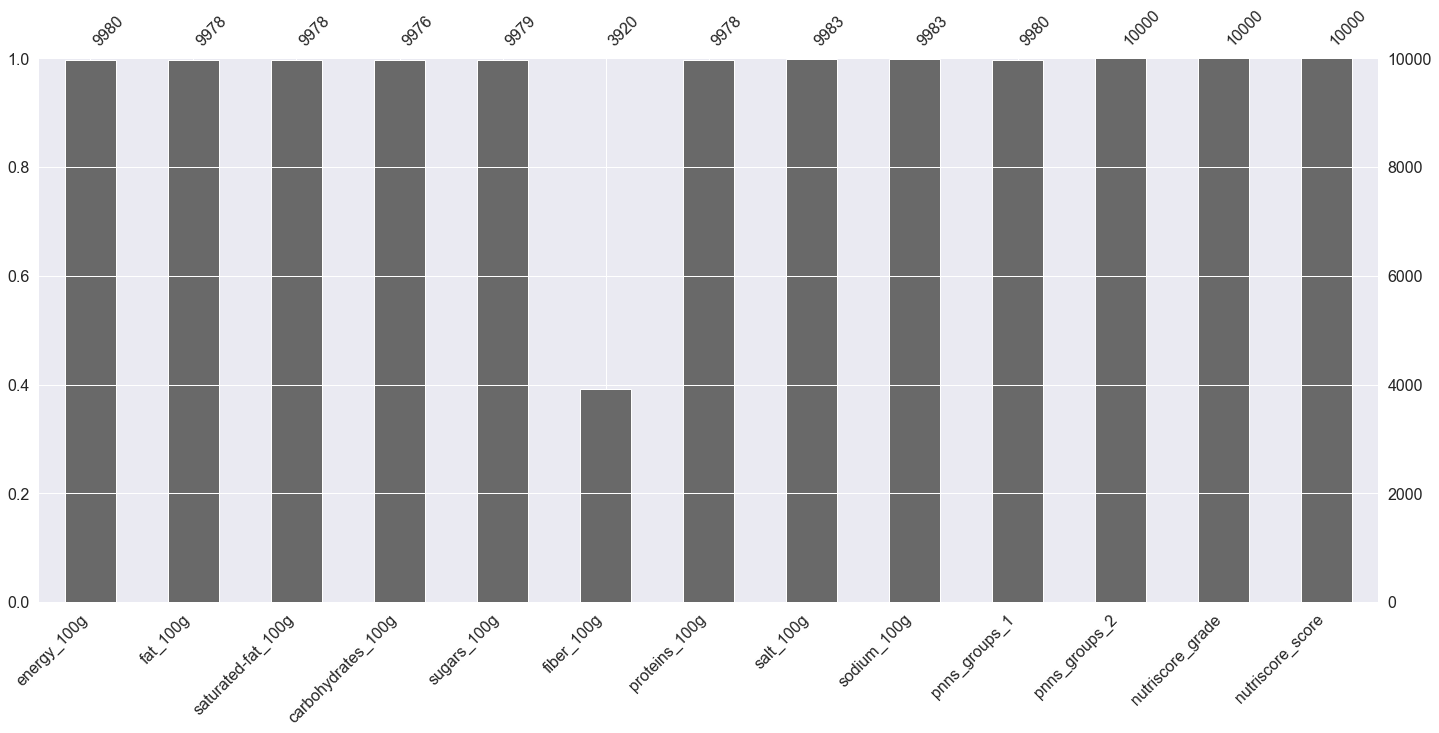

In [75]:
msno.bar(data.sample(10000))

In [79]:
data['fiber_100g'].value_counts()

0.000    16416
0.500     4250
1.000     2015
2.000     1829
3.000     1768
         ...  
0.012        1
8.390        1
0.980        1
4.610        1
2.650        1
Name: fiber_100g, Length: 906, dtype: int64

JEU DE DONNEES FINAL AVANT ANALYSE EXPLORATOIRE
----------------------------------------------------
Le jeu de données a 183634 lignes et 13 colonnes.
------------------------------------------------------
Le taux de remplissage global du jeu est de : 95.19%
------------------------------------------------------


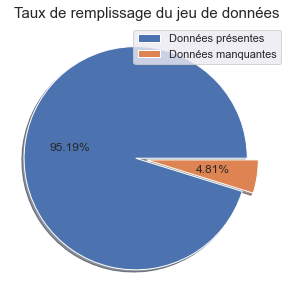

In [81]:
print('JEU DE DONNEES FINAL AVANT ANALYSE EXPLORATOIRE')
filling_rate(data)

**Le pourcentage de valeurs manquantes de 4.81 % se rapporte presque exclusivement à la variable 'fiber_100g' que l'on choisit de conserver néanmoins à ce stade.**

In [86]:
#Nombre de valeur manquante
def nombre_manquantes(data):
    return sum((data.isnull()/data.shape[0])*100)
# On applique cette fonction pour chaque colonne:
print("Valeurs manquantes par colonne en % :")
print(data.apply(nombre_manquantes, axis=0))

Valeurs manquantes par colonne en % :
energy_100g            0.157923
fat_100g               0.161190
saturated-fat_100g     0.159557
carbohydrates_100g     0.193864
sugars_100g            0.159012
fiber_100g            61.062222
proteins_100g          0.158467
salt_100g              0.118170
sodium_100g            0.118170
pnns_groups_1          0.253766
pnns_groups_2          0.000000
nutriscore_grade       0.000000
nutriscore_score       0.000000
dtype: float64


In [93]:
nb_rows, nb_columns = data.shape
nb_total_donnees = nb_rows * nb_columns
nb_manquantes_fiber = sum(data['fiber_100g'].isnull())
Taux_manquantes_fiber_sur_jeu_total = round((nb_manquantes_fiber / nb_total_donnees) * 100, 2)
print('Taux de valeurs manquantes de fiber par rapport au jeu total = ',Taux_manquantes_fiber_sur_jeu_total, ' %')

Taux de valeurs manquantes de fiber par rapport au jeu total =  4.7  %


## 8. Sauvegarde du fichier nettoyé

In [77]:
data_cleaned = data

data_cleaned.to_csv("C:\openclassrooms\Projet_3\data_cleaned.csv")

data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183634 entries, 0 to 183633
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   energy_100g         183344 non-null  float32
 1   fat_100g            183338 non-null  float32
 2   saturated-fat_100g  183341 non-null  float32
 3   carbohydrates_100g  183278 non-null  float32
 4   sugars_100g         183342 non-null  float32
 5   fiber_100g          71503 non-null   float32
 6   proteins_100g       183343 non-null  float32
 7   salt_100g           183417 non-null  float32
 8   sodium_100g         183417 non-null  float32
 9   pnns_groups_1       183168 non-null  object 
 10  pnns_groups_2       183634 non-null  object 
 11  nutriscore_grade    183634 non-null  object 
 12  nutriscore_score    183634 non-null  float32
dtypes: float32(10), object(3)
memory usage: 11.2+ MB


## 9. ANNEXES - Test AUTOVIZ : Moteur de visualisation

* **TEST AUTOVIZ : Moteur de visualisation**

In [78]:
import pandas as pd

from autoviz.AutoViz_Class import AutoViz_Class
AV = AutoViz_Class()

test=pd.read_csv("C:\openclassrooms\Projet_3\data_cleaned.csv")

Imported AutoViz_Class version: 0.0.81. Call using:
    from autoviz.AutoViz_Class import AutoViz_Class
    AV = AutoViz_Class()
    AV.AutoViz(filename, sep=',', depVar='', dfte=None, header=0, verbose=0,
                            lowess=False,chart_format='svg',max_rows_analyzed=150000,max_cols_analyzed=30)
Note: verbose=0 or 1 generates charts and displays them in your local Jupyter notebook.
      verbose=2 saves plots in your local machine under AutoViz_Plots directory and does not display charts.


Shape of your Data Set: (183634, 14)
############## C L A S S I F Y I N G  V A R I A B L E S  ####################
Classifying variables in data set...
    Number of Numeric Columns =  10
    Number of Integer-Categorical Columns =  0
    Number of String-Categorical Columns =  2
    Number of Factor-Categorical Columns =  0
    Number of String-Boolean Columns =  0
    Number of Numeric-Boolean Columns =  0
    Number of Discrete String Columns =  1
    Number of NLP String Columns =  0
    Number of Date Time Columns =  0
    Number of ID Columns =  1
    Number of Columns to Delete =  0
    14 Predictors classified...
        This does not include the Target column(s)
        2 variables removed since they were ID or low-information variables
Since Number of Rows in data 183634 exceeds maximum, randomly sampling 150000 rows for EDA...
Number of All Scatter Plots = 55


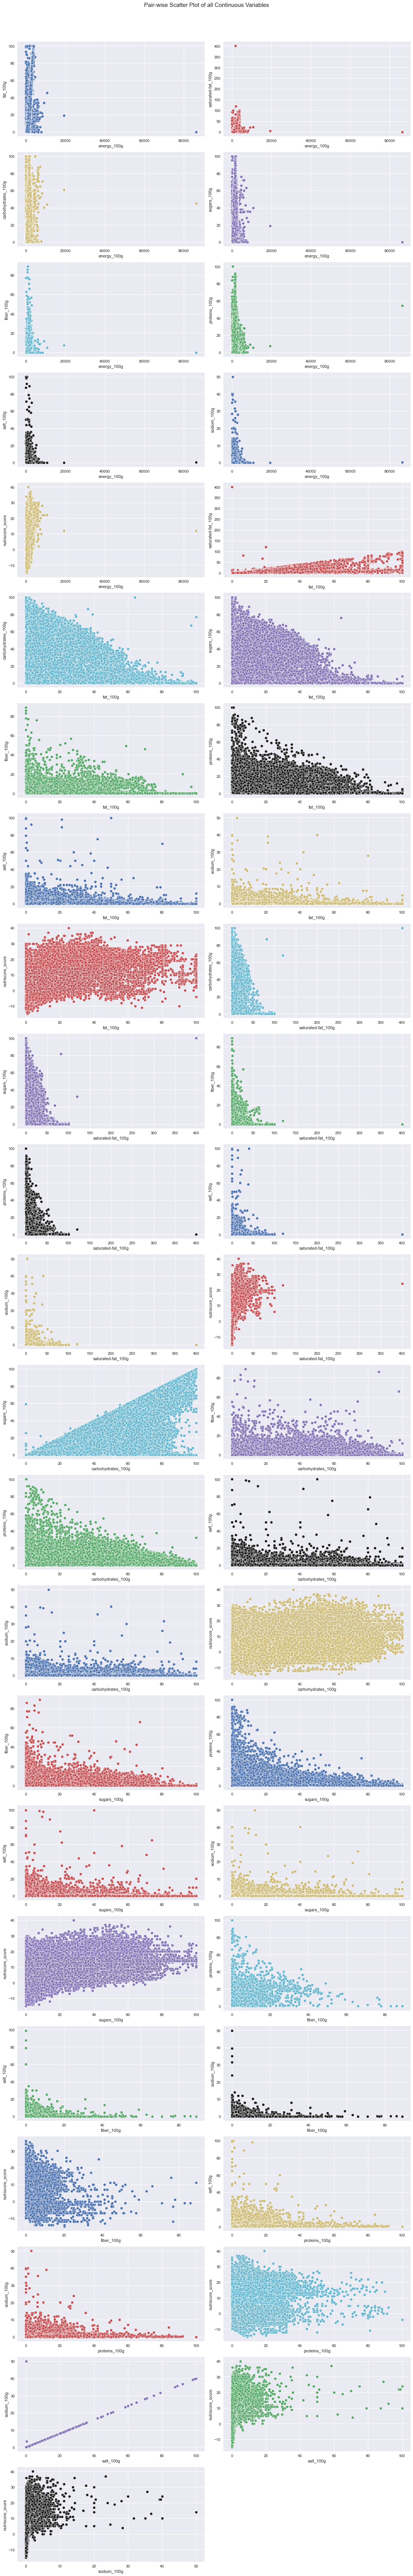

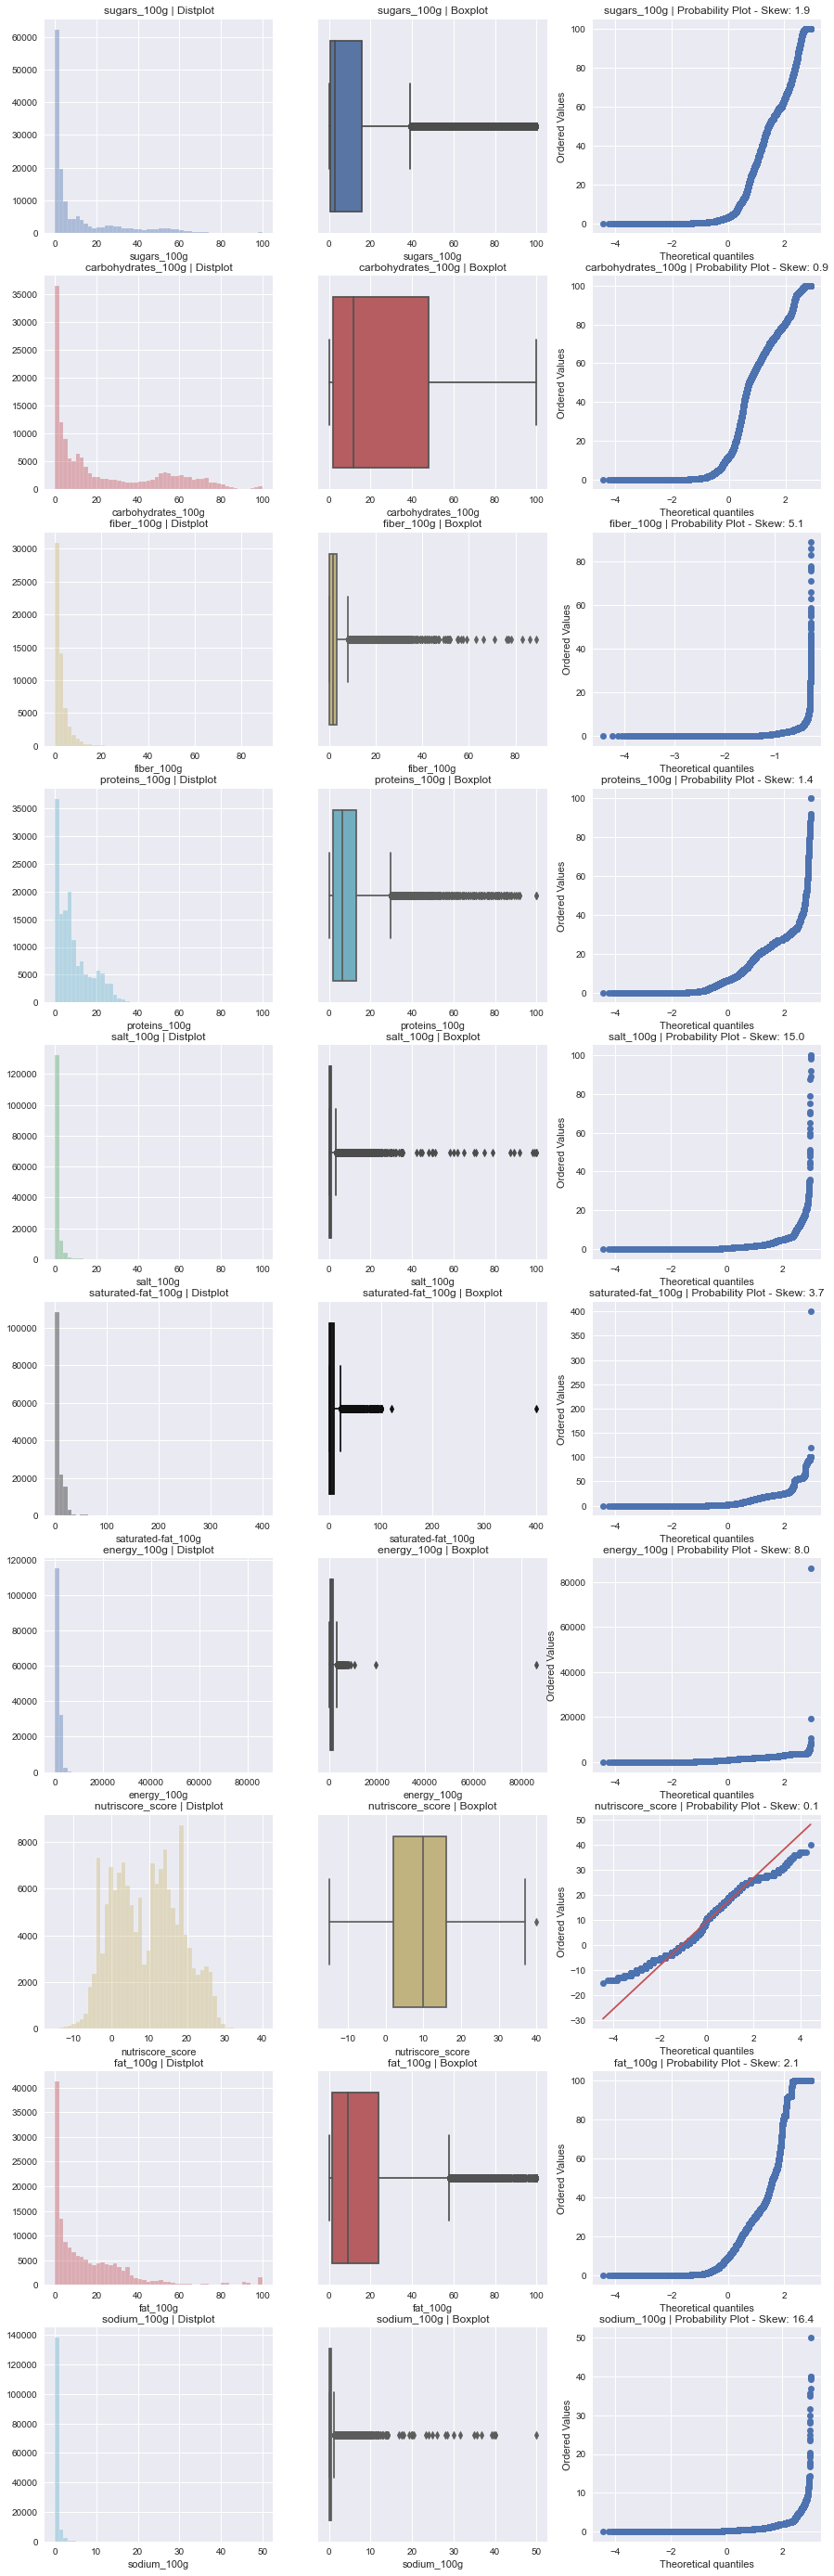

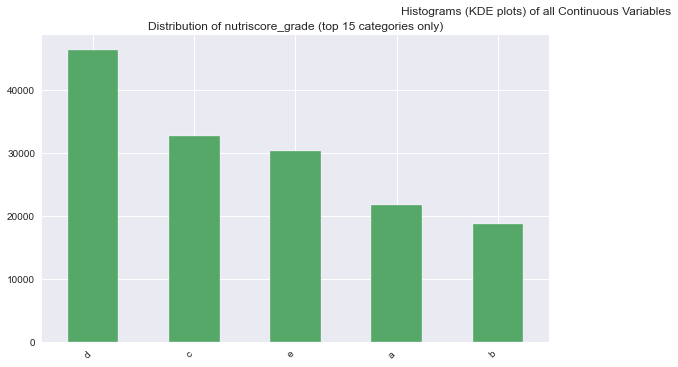

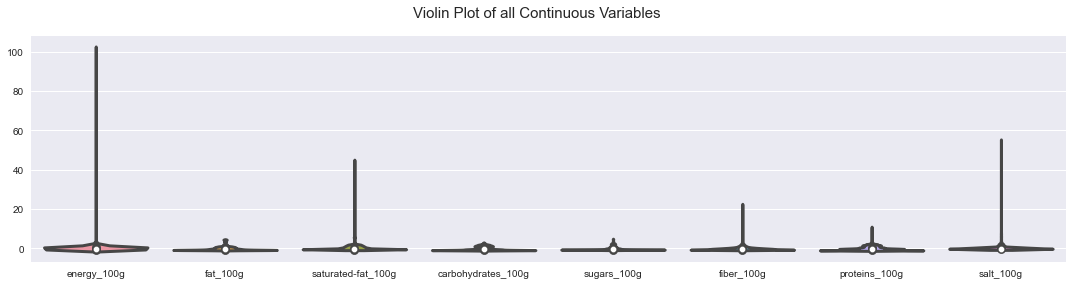

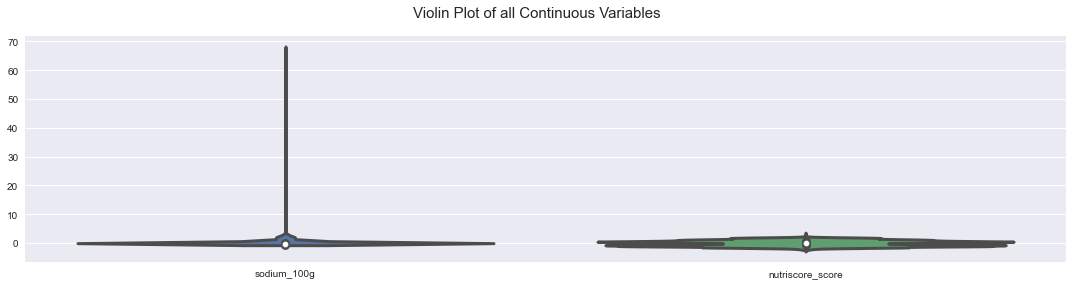

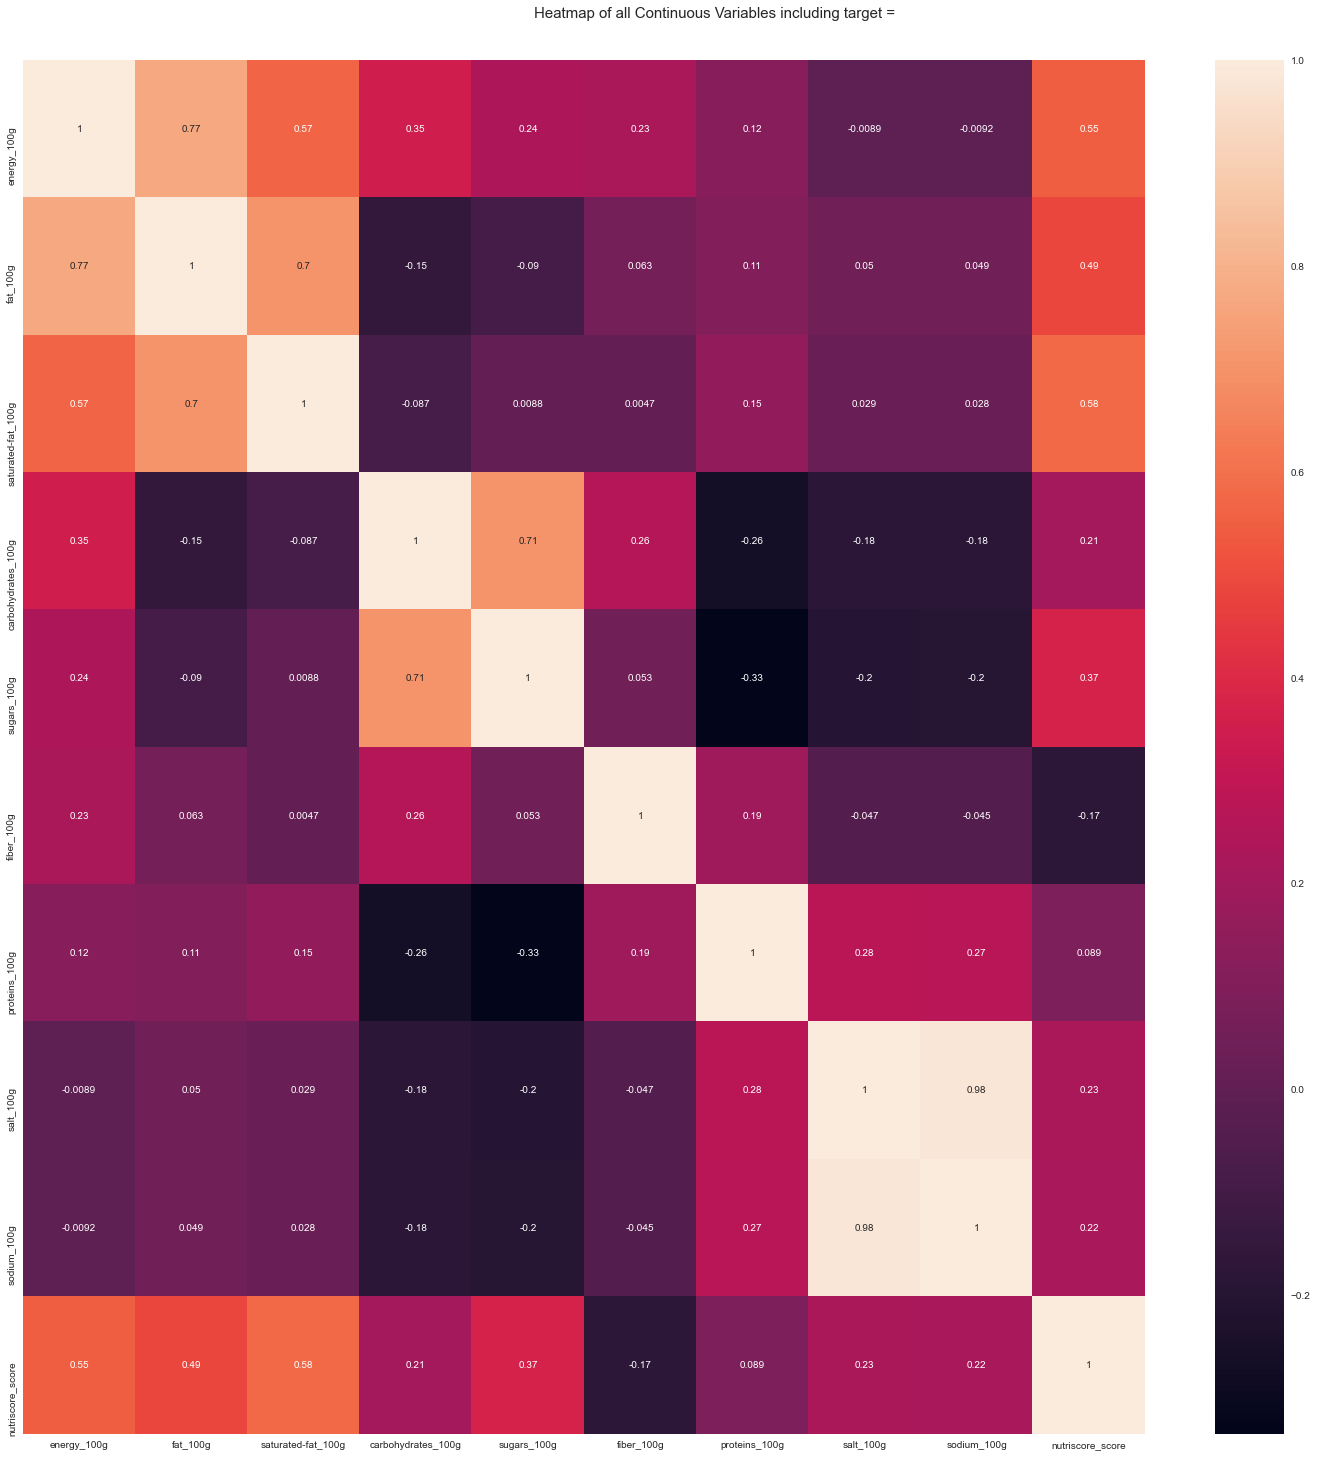

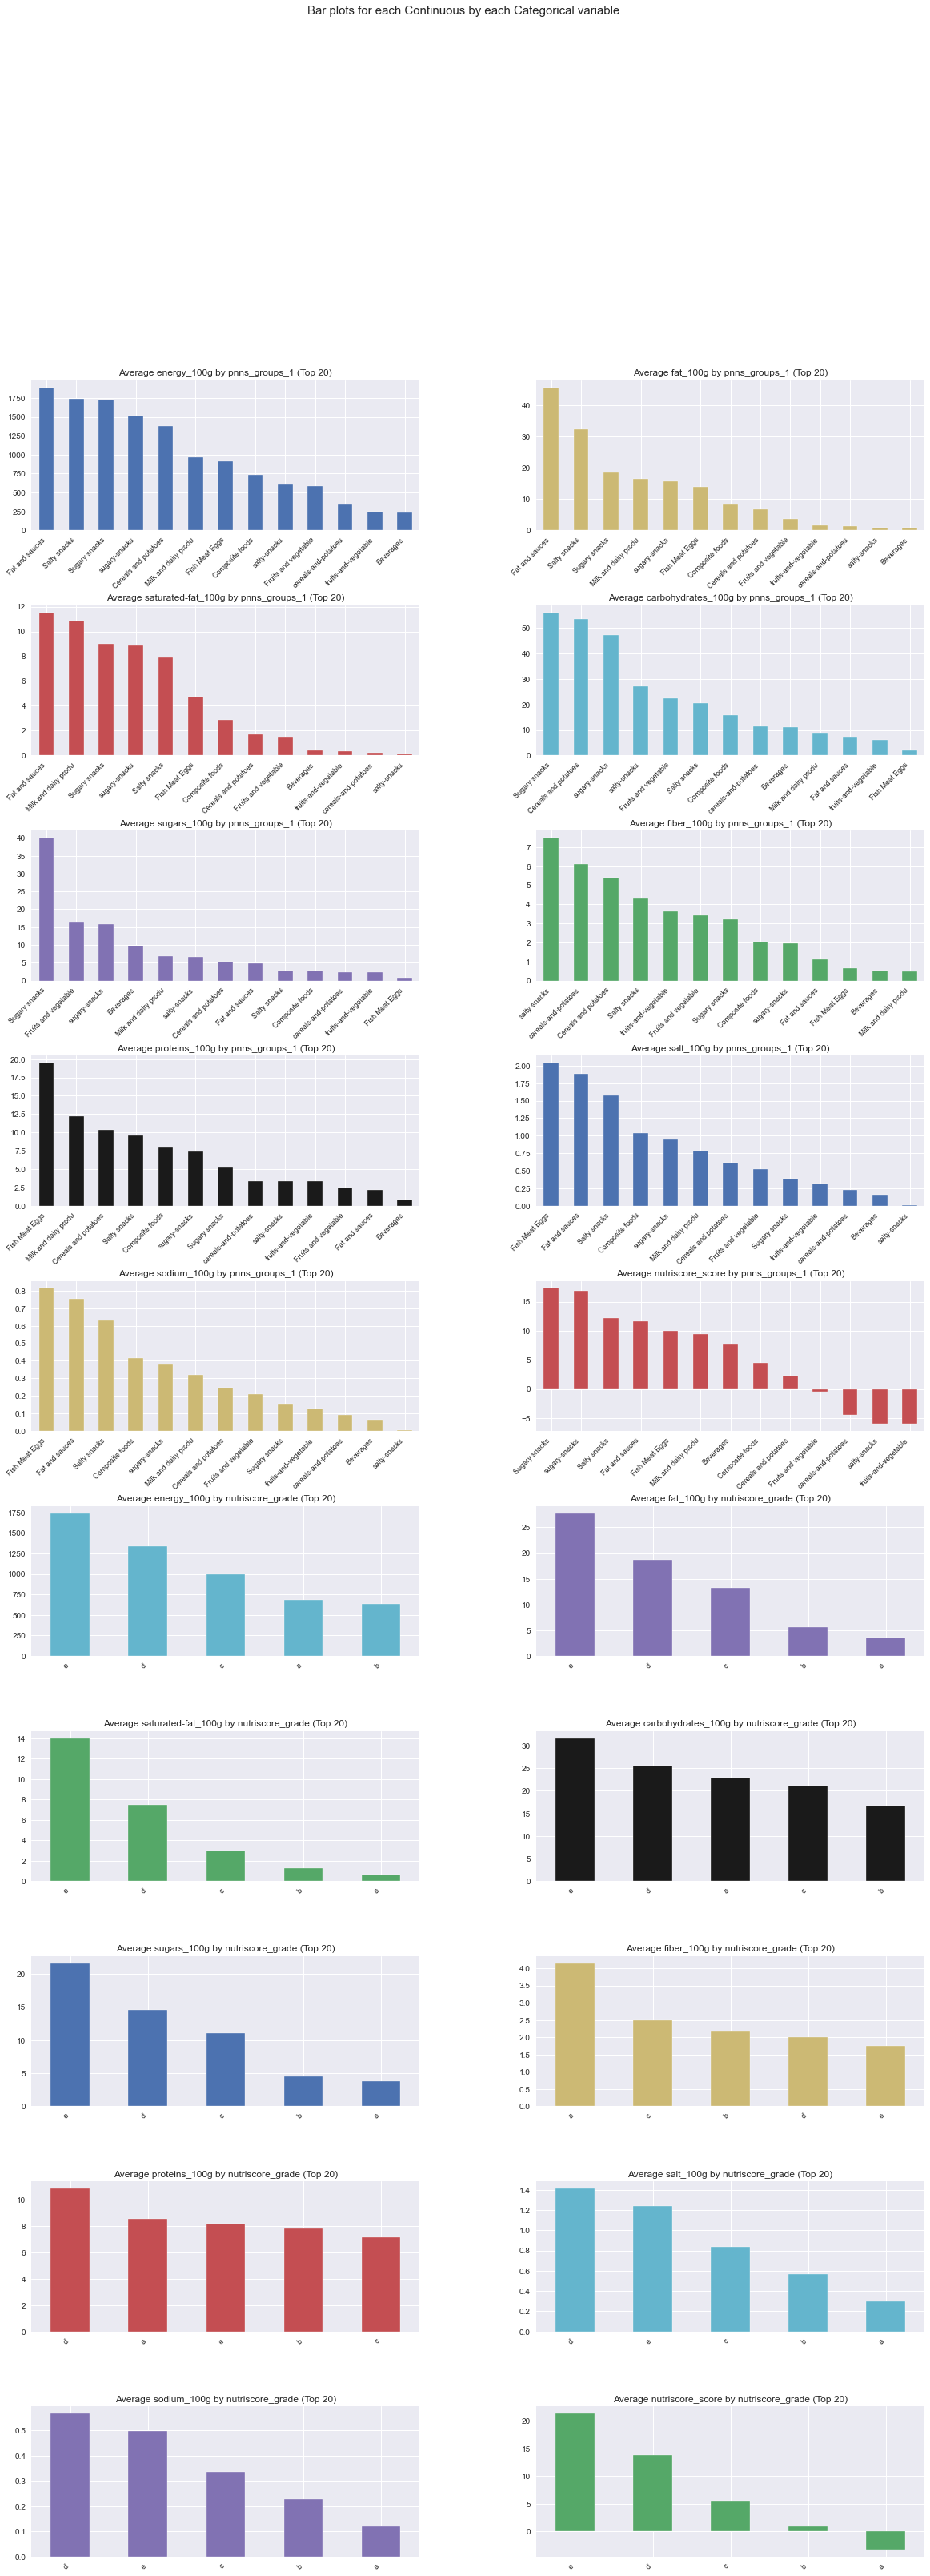

Time to run AutoViz (in seconds) = 28.908

 ###################### VISUALIZATION Completed ########################


In [79]:
df = AV.AutoViz ("C:\openclassrooms\Projet_3\data_cleaned.csv")